# Mount drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# !ls /content/gdrive/My\ Drive

In [ ]:
# !unzip /content/gdrive/MyDrive/Q56094077/snrs/hw1_0319/hw1_data.zip -d /content/gdrive/MyDrive/Q56094077/snrs/hw1_0319

# Import Library

In [1]:
import os

import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import json

from tqdm import tqdm
from datetime import datetime
import time
import matplotlib.pyplot as plt

In [2]:
import drbc
import utils
import utils.data
import utils.eval

In [3]:
import networkit as nk
import networkx as nx

# Setting

In [4]:
class Setting:
    _root = os.getcwd()

    _data = os.path.join(_root, "hw1_data")

    data_synthetic = os.path.join(_data, "Synthetic", "5000")
    
    data_youtube = os.path.join(_data, "Real", "youtube")
    data_amazon = os.path.join(_data, "Real", "amazon")
    data_dblp = os.path.join(_data, "Real", "dblp")
    data_comlj = os.path.join(_data, "Real", "com-lj")
    
    data_train = os.path.join(_data, "train")
    data_valid = os.path.join(_data, "valid")
    
    ### Data split
    data_split = os.path.join(_root, "split.json")
    

    # Setting of training
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

    epochs = 500
    nodes_cnt = 200
    
    params_drbc = dict(
        # according to source paper
        encoder_params = dict(
            c = 3,
            p = 128,
            num_layers = 5,
            device = device
        ),
        decoder_params = dict(
            p = 128,
            q = 64
        )
    )

    
    def __init__(self, date_time=None):
        
    
        # Create dir for train/test
        self.root = os.path.join(self._root, "result", "scales", date_time)
        if os.path.exists(self.root):
            pass
        else:
            os.makedirs(self.root)


        ### Save plt info
        self.train_info_p = os.path.join(self.root, "train.json")
        self.val_info_p = os.path.join(self.root, "valid.json")

        ### Save plt img
        self.result_plt_p = os.path.join(self.root, "train_plt.png")
    
        self.weight_drbc = os.path.join(self.root, "drbc.pth")
    

In [ ]:
# date_time = datetime.strftime(datetime.now(), "%Y-%m-%d %H-%M")
date_time = "2021-03-21 04-23"

In [5]:
setting = Setting(date_time=date_time)
setting.root

# Data

- data.x	节点特征，维度是[num_nodes, num_node_features]。
- data.edge_index	维度是[2, num_edges]，描述图中节点的关联关系，每一列对应的两个元素，分别是边的起点和重点。数据类型是torch.long。需要注意的是，data.edge_index是定义边的节点的张量（tensor），而不是节点的列表（list）。
- data.edge_attr	边的特征矩阵，维度是[num_edges, num_edge_features]
- data.y	训练目标（维度可以是任意的）。对于节点相关的任务，维度为[num_nodes, *]；对于图相关的任务，维度为[1,*]。
- data.position	节点位置矩阵（Node position matrix），维度为[num_nodes, num_dimensions]。

- [Learning to Identify High Betweenness Centrality Nodes from
Scratch: A Novel Graph Neural Network Approach](https://arxiv.org/pdf/1905.10418.pdf)
- node initial feature = [$(d_v), 1, 1]

## Read data

### Load test data

In [12]:
syn, syn_score = utils.data.load_data(Setting.data_synthetic, mode="between")
yt, yt_score = utils.data.load_data(Setting.data_youtube, mode="between")
amazon, amazon_score = utils.data.load_data(Setting.data_amazon, mode="between")
dblp, dblp_score = utils.data.load_data(Setting.data_dblp, mode="between")
comlj, comlj_score = utils.data.load_data(Setting.data_comlj, mode="between")

In [13]:
train, train_score = utils.data.load_data(os.path.join(setting.data_train, str(Setting.nodes_cnt)))

In [14]:
valid, valid_score = utils.data.load_data(os.path.join(setting.data_valid, str(Setting.nodes_cnt)))

### Cvt to data/dataloader

In [15]:
train_loader = utils.data.to_dataloader(train, train_score, batch=8)
valid_loader = utils.data.to_dataloader(valid, valid_score, batch=8)

In [16]:
syn_loader = utils.data.to_dataloader(syn, syn_score, batch=1, usecols=1)

In [17]:
yt_loader = utils.data.to_dataloader(yt, yt_score, batch=1, y_sep=":", usecols=1)

In [ ]:
amazon_loader = utils.data.to_dataloader(amazon, amazon_score, batch=1, y_sep=":", usecols=1)

In [ ]:
dblp_loader = utils.data.to_dataloader(dblp, dblp_score, batch=1, y_sep=":", usecols=1)

In [ ]:
comlj_loader = utils.data.to_dataloader(comlj, comlj_score, batch=1, y_sep=":", usecols=1)

# Model

In [29]:
model, optimizer = drbc.load_checkpoint(
                    setting.weight_drbc,
                    Setting.device,
                    drbc = Setting.params_drbc)

model

use a new optimizer


DrBC(
  (encoder): Encoder(
    (w_0): Linear(in_features=3, out_features=128, bias=True)
    (relu): ReLU(inplace=True)
    (rnn): GRUCell(128, 128)
  )
  (decoder): Decoder(
    (w_4): Linear(in_features=128, out_features=64, bias=True)
    (w_5): Linear(in_features=64, out_features=1, bias=True)
    (relu): ReLU(inplace=True)
  )
)

## DrBC

In [30]:
nodes_cnt = Setting.nodes_cnt


model.train()

train_info = {
    "bce": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

valid_info = {
    "bce": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

top_10 = 0.0
top_5 = 0.0
top_1 = 0.0

for epoch in range(Setting.epochs):
    
#     G, bc_gt = generate_nx_graph(nodes_cnt)
    
#     # Convert networkx.Graph to Pyg Data
#     G = from_networkx(G)

    print("\nEpoch: {}".format(epoch+1))

    for batch in tqdm(train_loader):
    
        ### Start training
        optimizer.zero_grad()
        batch = batch.to(Setting.device)

        bc_pr = model(batch)
    
        
        # compute batch loss
        b_index = batch.batch.cpu().numpy()
        b = np.max(b_index) + 1
        
        batch_loss = torch.tensor(0, dtype=torch.float).to(Setting.device)
        
        for b_ in range(b):
            
            indice, = np.where(b_index == b_)
            
            gt = batch.y[indice].squeeze()
            pr = bc_pr[indice].squeeze()
            
            # random sample 5|V| nodes
            src = np.random.choice(len(indice), 5*len(indice), replace=True)
            det = np.random.choice(len(indice), 5*len(indice), replace=True)
            src = torch.from_numpy(src)
            det = torch.from_numpy(det)

            
            y_gt = gt[det] - gt[src]
            y_pr = pr[det] - pr[src]
            
            y_gt = nn.Sigmoid()(y_gt)
            y_pr = nn.Sigmoid()(y_pr)
        
            batch_loss += nn.BCELoss()(y_pr, y_gt)
        
        batch_loss = torch.div(batch_loss, b)
        batch_loss.backward()
        optimizer.step()
    
    
    ### Evaluation
    with torch.no_grad():
        
        
        top1_list = []
        top5_list = []
        top10_list = []
        kendal_list = []
        loss_list = []
        
        for batch in tqdm(train_loader):

            batch = batch.to(Setting.device)

            bc_pr = model(batch)

            b_index = batch.batch.cpu().numpy()
            b = np.max(b_index) + 1

            for b_ in range(b):

                indice, = np.where(b_index == b_)

                gt = batch.y[indice].squeeze()
                pr = bc_pr[indice].squeeze()
                
                # evaluation
                top1 = utils.eval.top_n_percentage(gt, pr, k=1, device=Setting.device)
                top5 = utils.eval.top_n_percentage(gt, pr, k=5, device=Setting.device)
                top10 = utils.eval.top_n_percentage(gt, pr, k=10, device=Setting.device)
                kendal = utils.eval.kendal_tau_distance(gt, pr)
                

                # compute loss
                src = np.random.choice(len(indice), 5*len(indice), replace=True)
                det = np.random.choice(len(indice), 5*len(indice), replace=True)
                src = torch.from_numpy(src)
                det = torch.from_numpy(det)

                y_gt = gt[det] - gt[src]
                y_pr = pr[det] - pr[src]

                y_gt = nn.Sigmoid()(y_gt)
                y_pr = nn.Sigmoid()(y_pr)

                loss = nn.BCELoss()(y_pr, y_gt)
                
                top1_list.append(top1)
                top5_list.append(top5)
                top10_list.append(top10)
                kendal_list.append(kendal)
                loss_list.append(loss.item())
                

        bce = sum(loss_list)/len(loss_list)
        top1 = sum(top1_list)/len(top1_list)
        top5 = sum(top5_list)/len(top5_list)
        top10 = sum(top10_list)/len(top10_list)
        kendal = sum(kendal_list)/len(kendal_list)      
        
                
        print("Train: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
                bce,
                top1,
                top5,
                top10,
                kendal
        ))

        train_info["bce"].append(bce)
        train_info["top1"].append(top1)
        train_info["top5"].append(top5)
        train_info["top10"].append(top10)
        train_info["kendal"].append(kendal)

        with open(setting.train_info_p, 'w') as f:
            json.dump(train_info, f)
            
            
    
        top1_list = []
        top5_list = []
        top10_list = []
        kendal_list = []
        loss_list = []
        
        for batch in tqdm(valid_loader):

            batch = batch.to(Setting.device)

            bc_pr = model(batch)

            b_index = batch.batch.cpu().numpy()
            b = np.max(b_index) + 1

            for b_ in range(b):

                indice, = np.where(b_index == b_)
            

                gt = batch.y[indice].squeeze()
                pr = bc_pr[indice].squeeze()
                
                # evaluation
                top1 = utils.eval.top_n_percentage(gt, pr, k=1, device=Setting.device)
                top5 = utils.eval.top_n_percentage(gt, pr, k=5, device=Setting.device)
                top10 = utils.eval.top_n_percentage(gt, pr, k=10, device=Setting.device)
                kendal = utils.eval.kendal_tau_distance(gt, pr)

                # compute loss
                src = np.random.choice(len(indice), 5*len(indice), replace=True)
                det = np.random.choice(len(indice), 5*len(indice), replace=True)
                src = torch.from_numpy(src)
                det = torch.from_numpy(det)

                y_gt = gt[det] - gt[src]
                y_pr = pr[det] - pr[src]

                y_gt = nn.Sigmoid()(y_gt)
                y_pr = nn.Sigmoid()(y_pr)

                loss = nn.BCELoss()(y_pr, y_gt)
                
                top1_list.append(top1)
                top5_list.append(top5)
                top10_list.append(top10)
                kendal_list.append(kendal)
                loss_list.append(loss.item())
                

        bce = sum(loss_list)/len(loss_list)
        top1 = sum(top1_list)/len(top1_list)
        top5 = sum(top5_list)/len(top5_list)
        top10 = sum(top10_list)/len(top10_list)
        kendal = sum(kendal_list)/len(kendal_list)      
        
                
        print("Valid: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
                bce,
                top1,
                top5,
                top10,
                kendal
        ))

        valid_info["bce"].append(bce)
        valid_info["top1"].append(top1)
        valid_info["top5"].append(top5)
        valid_info["top10"].append(top10)
        valid_info["kendal"].append(kendal)

        with open(setting.val_info_p, 'w') as f:
            json.dump(valid_info, f)



        if top10 > top_10:
            checkpoint = {
                'model_stat': model.state_dict(),
                'optimizer_stat': optimizer.state_dict(),
            }
            top_10 = top10
            
            torch.save(checkpoint, setting.weight_drbc)

  0%|          | 0/313 [00:00<?, ?it/s]


Epoch: 1


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930634998344595, top 1 = 0.91135, top 5 = 0.9419399999999166, top 10 = 0.9377599999999513, kendal = 0.821651201633569


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930695040855795, top 1 = 0.9, top 5 = 0.9340000000000005, top 10 = 0.9355000000000006, kendal = 0.8208900642072376

Epoch: 2


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624843048928, top 1 = 0.94285, top 5 = 0.9560299999999304, top 10 = 0.9544649999999701, kendal = 0.8574580596470803


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930665612616034, top 1 = 0.955, top 5 = 0.9490000000000003, top 10 = 0.9570000000000007, kendal = 0.8556870447883722

Epoch: 3


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930626569861508, top 1 = 0.9512, top 5 = 0.9623699999999386, top 10 = 0.9608349999999791, kendal = 0.8714053971661185


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693065013217882, top 1 = 0.955, top 5 = 0.9510000000000002, top 10 = 0.959500000000001, kendal = 0.871121228395328

Epoch: 4


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624309470451, top 1 = 0.95795, top 5 = 0.9657999999999429, top 10 = 0.962814999999981, kendal = 0.8750322317917822


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930663576920133, top 1 = 0.955, top 5 = 0.9550000000000003, top 10 = 0.9610000000000012, kendal = 0.8747272593036673

Epoch: 5


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623146930402, top 1 = 0.9602, top 5 = 0.9674099999999458, top 10 = 0.963929999999981, kendal = 0.876770822555891


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930659310149702, top 1 = 0.95, top 5 = 0.9570000000000002, top 10 = 0.9620000000000011, kendal = 0.8762438405515521

Epoch: 6


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624023112939, top 1 = 0.96255, top 5 = 0.968399999999948, top 10 = 0.9649499999999834, kendal = 0.8786998177050149


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930658672849439, top 1 = 0.945, top 5 = 0.9540000000000002, top 10 = 0.9645000000000009, kendal = 0.8781383148578297

Epoch: 7


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062501560141, top 1 = 0.963, top 5 = 0.9691499999999486, top 10 = 0.9656099999999836, kendal = 0.8789022541028476


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930663230140867, top 1 = 0.94, top 5 = 0.9560000000000002, top 10 = 0.965000000000001, kendal = 0.8783111822350314

Epoch: 8


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622830425355, top 1 = 0.96345, top 5 = 0.969669999999949, top 10 = 0.9658349999999846, kendal = 0.880074608211351


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930659126813056, top 1 = 0.95, top 5 = 0.9610000000000002, top 10 = 0.9660000000000011, kendal = 0.8796217377009045

Epoch: 9


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624739767418, top 1 = 0.9635, top 5 = 0.9699799999999495, top 10 = 0.9662399999999854, kendal = 0.8815054123064551


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930662653114177, top 1 = 0.94, top 5 = 0.9580000000000003, top 10 = 0.9655000000000009, kendal = 0.8811463649074427

Epoch: 10


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062451174533, top 1 = 0.96405, top 5 = 0.9705899999999503, top 10 = 0.966799999999986, kendal = 0.8817371242144502


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930678098950609, top 1 = 0.94, top 5 = 0.9600000000000003, top 10 = 0.966000000000001, kendal = 0.8814046585112201

Epoch: 11


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625987881873, top 1 = 0.96475, top 5 = 0.9709099999999504, top 10 = 0.9668449999999867, kendal = 0.8824932670866001


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930648860385413, top 1 = 0.945, top 5 = 0.9630000000000003, top 10 = 0.9660000000000011, kendal = 0.8823252636727865

Epoch: 12


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623261646743, top 1 = 0.96505, top 5 = 0.9711899999999505, top 10 = 0.9673199999999875, kendal = 0.8816777740086718


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693066032233905, top 1 = 0.945, top 5 = 0.9640000000000003, top 10 = 0.9655000000000009, kendal = 0.8817875773518139

Epoch: 13


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623700249908, top 1 = 0.9654, top 5 = 0.9714499999999505, top 10 = 0.9676899999999883, kendal = 0.88271933749897


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930664461650151, top 1 = 0.945, top 5 = 0.9630000000000003, top 10 = 0.966000000000001, kendal = 0.882792604901715

Epoch: 14


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624001824249, top 1 = 0.96485, top 5 = 0.9716299999999511, top 10 = 0.9678649999999883, kendal = 0.8832534503009323


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930659984111598, top 1 = 0.95, top 5 = 0.9640000000000003, top 10 = 0.966000000000001, kendal = 0.883496124333112

Epoch: 15


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930626201015125, top 1 = 0.9648, top 5 = 0.9721099999999515, top 10 = 0.9680399999999889, kendal = 0.8800209419951021


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930651330593561, top 1 = 0.95, top 5 = 0.9640000000000003, top 10 = 0.966000000000001, kendal = 0.8802297936596815

Epoch: 16


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062340714825, top 1 = 0.96495, top 5 = 0.9722899999999524, top 10 = 0.9682149999999888, kendal = 0.8821955485176297


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930663899864379, top 1 = 0.95, top 5 = 0.9640000000000003, top 10 = 0.966500000000001, kendal = 0.8826569308027381

Epoch: 17


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624177589051, top 1 = 0.96555, top 5 = 0.9724199999999522, top 10 = 0.9683799999999902, kendal = 0.8825207244828871


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930661499020626, top 1 = 0.95, top 5 = 0.9640000000000003, top 10 = 0.967500000000001, kendal = 0.8829865801550685

Epoch: 18


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.69306237525379, top 1 = 0.96565, top 5 = 0.9726899999999525, top 10 = 0.9684999999999895, kendal = 0.8836501415253802


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930647420911193, top 1 = 0.94, top 5 = 0.9640000000000003, top 10 = 0.967000000000001, kendal = 0.8842418567390011

Epoch: 19


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624584629479, top 1 = 0.96645, top 5 = 0.9728699999999528, top 10 = 0.96860999999999, kendal = 0.8842880824551043


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930671171612525, top 1 = 0.945, top 5 = 0.9660000000000002, top 10 = 0.9670000000000012, kendal = 0.8847443697563666

Epoch: 20


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622651576938, top 1 = 0.96655, top 5 = 0.9729599999999531, top 10 = 0.9688999999999905, kendal = 0.8850453889291795


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693067084724647, top 1 = 0.94, top 5 = 0.9660000000000002, top 10 = 0.966500000000001, kendal = 0.8854107019702198

Epoch: 21


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930626405658366, top 1 = 0.9669, top 5 = 0.9732199999999531, top 10 = 0.9688449999999906, kendal = 0.88526425999561


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930655300683827, top 1 = 0.95, top 5 = 0.9650000000000003, top 10 = 0.9675000000000011, kendal = 0.8857383405147147

Epoch: 22


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622917412416, top 1 = 0.96725, top 5 = 0.9732499999999537, top 10 = 0.9689749999999906, kendal = 0.8844754526039201


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930666243457346, top 1 = 0.95, top 5 = 0.9670000000000002, top 10 = 0.9670000000000012, kendal = 0.8849705016722745

Epoch: 23


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621605215501, top 1 = 0.9676, top 5 = 0.9734599999999538, top 10 = 0.9691249999999906, kendal = 0.8857452751773073


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930663507314716, top 1 = 0.94, top 5 = 0.9670000000000002, top 10 = 0.966500000000001, kendal = 0.8862860803698126

Epoch: 24


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621899194037, top 1 = 0.96755, top 5 = 0.9735499999999538, top 10 = 0.9692199999999904, kendal = 0.8869069782068113


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930666632560611, top 1 = 0.94, top 5 = 0.9660000000000002, top 10 = 0.967000000000001, kendal = 0.8874679897660342

Epoch: 25


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062227118419, top 1 = 0.96775, top 5 = 0.9736199999999535, top 10 = 0.9693299999999908, kendal = 0.8870830786504812


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930665037948464, top 1 = 0.94, top 5 = 0.9670000000000002, top 10 = 0.966500000000001, kendal = 0.8875363307169916

Epoch: 26


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624752206759, top 1 = 0.9678, top 5 = 0.9737399999999534, top 10 = 0.969514999999991, kendal = 0.8884274082330592


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693067923273532, top 1 = 0.945, top 5 = 0.9670000000000002, top 10 = 0.9670000000000012, kendal = 0.8888549237070685

Epoch: 27


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623691607246, top 1 = 0.9684, top 5 = 0.9737999999999536, top 10 = 0.9695349999999913, kendal = 0.8895331011701358


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930676116931361, top 1 = 0.955, top 5 = 0.9680000000000001, top 10 = 0.9670000000000012, kendal = 0.8899001495851933

Epoch: 28


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062590698837, top 1 = 0.96845, top 5 = 0.9737899999999532, top 10 = 0.9696249999999914, kendal = 0.8879013825094871


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930665575180504, top 1 = 0.955, top 5 = 0.9670000000000002, top 10 = 0.9670000000000012, kendal = 0.888165475359763

Epoch: 29


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062646778557, top 1 = 0.96825, top 5 = 0.9737199999999532, top 10 = 0.9696899999999908, kendal = 0.8885881921263935


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693067354069874, top 1 = 0.955, top 5 = 0.9670000000000002, top 10 = 0.9670000000000012, kendal = 0.8890961299392418

Epoch: 30


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625129975567, top 1 = 0.96845, top 5 = 0.9739899999999536, top 10 = 0.9698299999999915, kendal = 0.8893100403542774


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930669146620021, top 1 = 0.945, top 5 = 0.9670000000000002, top 10 = 0.9675000000000011, kendal = 0.8897031637514681

Epoch: 31


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062367861062, top 1 = 0.96855, top 5 = 0.9740499999999538, top 10 = 0.9698349999999913, kendal = 0.8890117120183356


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930663223269581, top 1 = 0.95, top 5 = 0.9680000000000001, top 10 = 0.9675000000000011, kendal = 0.889424772650266

Epoch: 32


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625294067645, top 1 = 0.96845, top 5 = 0.9741599999999538, top 10 = 0.9699049999999925, kendal = 0.8887494059515378


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930660508073578, top 1 = 0.955, top 5 = 0.9670000000000002, top 10 = 0.9675000000000011, kendal = 0.8890609511305156

Epoch: 33


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622809359388, top 1 = 0.96885, top 5 = 0.9743799999999541, top 10 = 0.9700499999999916, kendal = 0.8892911614883114


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930671930688106, top 1 = 0.95, top 5 = 0.9680000000000001, top 10 = 0.9680000000000011, kendal = 0.889522257991466

Epoch: 34


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622213924523, top 1 = 0.96885, top 5 = 0.974399999999954, top 10 = 0.9701149999999923, kendal = 0.8902773200835349


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930637171978385, top 1 = 0.955, top 5 = 0.9680000000000001, top 10 = 0.9680000000000011, kendal = 0.8904076858594769

Epoch: 35


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623964433283, top 1 = 0.96865, top 5 = 0.9743899999999541, top 10 = 0.9701299999999919, kendal = 0.8905283151139658


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930669414246456, top 1 = 0.95, top 5 = 0.9690000000000001, top 10 = 0.9675000000000011, kendal = 0.8906418558804046

Epoch: 36


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624831277649, top 1 = 0.96875, top 5 = 0.9744299999999539, top 10 = 0.9700699999999913, kendal = 0.8910692050790873


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930670218506303, top 1 = 0.95, top 5 = 0.9680000000000001, top 10 = 0.9675000000000011, kendal = 0.8912629621151221

Epoch: 37


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625081846781, top 1 = 0.9687, top 5 = 0.9745599999999542, top 10 = 0.970224999999992, kendal = 0.8909146735160671


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930655485301307, top 1 = 0.95, top 5 = 0.9690000000000002, top 10 = 0.9675000000000011, kendal = 0.8908689917355659

Epoch: 38


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623566766895, top 1 = 0.9691, top 5 = 0.9746099999999538, top 10 = 0.9702349999999911, kendal = 0.8896337476557854


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930646769916102, top 1 = 0.95, top 5 = 0.97, top 10 = 0.968500000000001, kendal = 0.8896177357319405

Epoch: 39


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621700467259, top 1 = 0.96935, top 5 = 0.974689999999954, top 10 = 0.9704099999999928, kendal = 0.8912049281409098


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693065658267142, top 1 = 0.95, top 5 = 0.9690000000000001, top 10 = 0.9680000000000011, kendal = 0.8910971309491673

Epoch: 40


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622386392834, top 1 = 0.9698, top 5 = 0.9748699999999546, top 10 = 0.9704099999999926, kendal = 0.8912002882151017


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930650287229799, top 1 = 0.95, top 5 = 0.97, top 10 = 0.9690000000000011, kendal = 0.8906669802459031

Epoch: 41


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623437203117, top 1 = 0.96975, top 5 = 0.9748999999999549, top 10 = 0.9704449999999931, kendal = 0.8918893301587879


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930671240005987, top 1 = 0.945, top 5 = 0.9700000000000002, top 10 = 0.9690000000000011, kendal = 0.8914498950207908

Epoch: 42


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625240472637, top 1 = 0.9698, top 5 = 0.9748699999999549, top 10 = 0.970474999999992, kendal = 0.891596251455259


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930651966731207, top 1 = 0.95, top 5 = 0.9700000000000002, top 10 = 0.9690000000000009, kendal = 0.8911112017049705

Epoch: 43


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622729594934, top 1 = 0.9697, top 5 = 0.9751099999999547, top 10 = 0.9705799999999928, kendal = 0.89215549332211


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.69306694739386, top 1 = 0.95, top 5 = 0.9710000000000002, top 10 = 0.9695000000000009, kendal = 0.8917282876119107

Epoch: 44


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624126469814, top 1 = 0.9699, top 5 = 0.9750899999999553, top 10 = 0.9706599999999933, kendal = 0.8931190857329359


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930660310340785, top 1 = 0.95, top 5 = 0.9700000000000003, top 10 = 0.9695000000000009, kendal = 0.8925524084422007

Epoch: 45


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062282866223, top 1 = 0.96995, top 5 = 0.9750499999999551, top 10 = 0.9706349999999935, kendal = 0.8918710186792838


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930664030888251, top 1 = 0.95, top 5 = 0.9710000000000004, top 10 = 0.9695000000000009, kendal = 0.8913031608221389

Epoch: 46


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621278610646, top 1 = 0.96985, top 5 = 0.9750399999999548, top 10 = 0.9705149999999932, kendal = 0.8914921966924724


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930636032711428, top 1 = 0.95, top 5 = 0.9710000000000002, top 10 = 0.9695000000000009, kendal = 0.8909524088967521

Epoch: 47


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062351886137, top 1 = 0.9702, top 5 = 0.9751899999999554, top 10 = 0.970664999999993, kendal = 0.8927184558993009


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930640628640866, top 1 = 0.95, top 5 = 0.9710000000000002, top 10 = 0.969500000000001, kendal = 0.8923564302346435

Epoch: 48


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623396332211, top 1 = 0.97, top 5 = 0.9751499999999549, top 10 = 0.9706449999999932, kendal = 0.8916772955674607


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930657807784041, top 1 = 0.95, top 5 = 0.9720000000000002, top 10 = 0.9705000000000009, kendal = 0.8913514048564872

Epoch: 49


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062154887349, top 1 = 0.9705, top 5 = 0.9751899999999559, top 10 = 0.9707449999999926, kendal = 0.8925123598901404


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930651941732476, top 1 = 0.95, top 5 = 0.9710000000000002, top 10 = 0.9690000000000009, kendal = 0.892061958756684

Epoch: 50


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624755688919, top 1 = 0.97025, top 5 = 0.9750399999999554, top 10 = 0.9707299999999924, kendal = 0.8942006446485621


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930672517422347, top 1 = 0.955, top 5 = 0.9710000000000002, top 10 = 0.9690000000000011, kendal = 0.8937202505927633

Epoch: 51


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625550722727, top 1 = 0.97015, top 5 = 0.9752699999999559, top 10 = 0.9707499999999932, kendal = 0.8949152600072819


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693066545302446, top 1 = 0.955, top 5 = 0.9720000000000003, top 10 = 0.968000000000001, kendal = 0.894629798558732

Epoch: 52


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622186448475, top 1 = 0.9705, top 5 = 0.9754499999999559, top 10 = 0.9707999999999929, kendal = 0.8947568524648255


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930660551403417, top 1 = 0.95, top 5 = 0.9710000000000001, top 10 = 0.9685000000000009, kendal = 0.89433130698027

Epoch: 53


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623855158548, top 1 = 0.97015, top 5 = 0.975449999999956, top 10 = 0.9709849999999917, kendal = 0.8940685788474791


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930687671079544, top 1 = 0.95, top 5 = 0.9720000000000002, top 10 = 0.969500000000001, kendal = 0.893714222032938

Epoch: 54


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622129376823, top 1 = 0.97045, top 5 = 0.9754199999999561, top 10 = 0.9708999999999928, kendal = 0.8946104929602879


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930659980849567, top 1 = 0.955, top 5 = 0.9700000000000003, top 10 = 0.9685000000000009, kendal = 0.8943001512771338

Epoch: 55


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622145336076, top 1 = 0.97075, top 5 = 0.9755899999999563, top 10 = 0.9710549999999919, kendal = 0.8956519714531991


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930663087344044, top 1 = 0.95, top 5 = 0.9720000000000003, top 10 = 0.9690000000000011, kendal = 0.8953825638677451

Epoch: 56


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624130681903, top 1 = 0.97075, top 5 = 0.9755399999999561, top 10 = 0.9709649999999923, kendal = 0.8958396520898086


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930673757224352, top 1 = 0.955, top 5 = 0.9720000000000003, top 10 = 0.9685000000000009, kendal = 0.8954519115105155

Epoch: 57


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624520847997, top 1 = 0.971, top 5 = 0.9754099999999561, top 10 = 0.9709399999999919, kendal = 0.8953688078005229


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693066193369097, top 1 = 0.955, top 5 = 0.9720000000000003, top 10 = 0.9690000000000009, kendal = 0.8950076896221499

Epoch: 58


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623825126057, top 1 = 0.97135, top 5 = 0.9756399999999565, top 10 = 0.971074999999992, kendal = 0.8959537960479984


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930642741293073, top 1 = 0.955, top 5 = 0.9720000000000003, top 10 = 0.970000000000001, kendal = 0.895718243825381

Epoch: 59


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623850367358, top 1 = 0.9713, top 5 = 0.9755899999999558, top 10 = 0.9710799999999928, kendal = 0.8962626091186896


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930674486496258, top 1 = 0.955, top 5 = 0.9710000000000004, top 10 = 0.969500000000001, kendal = 0.8957574387699136

Epoch: 60


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623190036408, top 1 = 0.97095, top 5 = 0.9756699999999562, top 10 = 0.9710549999999925, kendal = 0.8959620864967884


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930674203612526, top 1 = 0.955, top 5 = 0.9710000000000004, top 10 = 0.9695000000000009, kendal = 0.8955815604082954

Epoch: 61


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623220297785, top 1 = 0.97125, top 5 = 0.9758499999999564, top 10 = 0.9711449999999926, kendal = 0.8968357705239325


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930660426814942, top 1 = 0.955, top 5 = 0.9710000000000004, top 10 = 0.9685000000000009, kendal = 0.8963966353811347

Epoch: 62


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624999547089, top 1 = 0.97145, top 5 = 0.975609999999956, top 10 = 0.9711799999999928, kendal = 0.8966929719879999


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930661704609256, top 1 = 0.955, top 5 = 0.9730000000000003, top 10 = 0.9685000000000009, kendal = 0.8963574399567976

Epoch: 63


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062354811106, top 1 = 0.97105, top 5 = 0.9758299999999568, top 10 = 0.9712799999999934, kendal = 0.8969920989396769


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930663245507876, top 1 = 0.955, top 5 = 0.9720000000000003, top 10 = 0.9685000000000009, kendal = 0.8965242737993647

Epoch: 64


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624352086541, top 1 = 0.9712, top 5 = 0.9756599999999562, top 10 = 0.9711649999999927, kendal = 0.8965270792795341


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930650020776994, top 1 = 0.95, top 5 = 0.9730000000000003, top 10 = 0.9690000000000009, kendal = 0.8958720126948545

Epoch: 65


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624886773415, top 1 = 0.9714, top 5 = 0.9758799999999564, top 10 = 0.9712949999999928, kendal = 0.8974125613148701


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930658820338258, top 1 = 0.95, top 5 = 0.9730000000000003, top 10 = 0.9690000000000011, kendal = 0.896821761362815

Epoch: 66


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623566368808, top 1 = 0.9714, top 5 = 0.9759599999999562, top 10 = 0.971279999999993, kendal = 0.896879081586565


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693067119066221, top 1 = 0.955, top 5 = 0.9720000000000003, top 10 = 0.9690000000000009, kendal = 0.8965102048617649

Epoch: 67


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930626002248323, top 1 = 0.97155, top 5 = 0.9757399999999565, top 10 = 0.971204999999993, kendal = 0.8972826348922552


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930668734914361, top 1 = 0.955, top 5 = 0.9730000000000003, top 10 = 0.967500000000001, kendal = 0.8968308074727948

Epoch: 68


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623498101843, top 1 = 0.97135, top 5 = 0.9757499999999567, top 10 = 0.9711949999999917, kendal = 0.8971288761033366


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930664557894484, top 1 = 0.96, top 5 = 0.9740000000000002, top 10 = 0.968000000000001, kendal = 0.8968006562139695

Epoch: 69


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623118134507, top 1 = 0.9714, top 5 = 0.9757699999999567, top 10 = 0.9712749999999926, kendal = 0.8972846092287937


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930641057213396, top 1 = 0.96, top 5 = 0.9730000000000003, top 10 = 0.968500000000001, kendal = 0.8968599536559891

Epoch: 70


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930626436155497, top 1 = 0.9716, top 5 = 0.9759399999999566, top 10 = 0.9713199999999933, kendal = 0.8974059103156722


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930675100740343, top 1 = 0.955, top 5 = 0.9730000000000003, top 10 = 0.9690000000000009, kendal = 0.8969815611911338

Epoch: 71


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625731943718, top 1 = 0.9712, top 5 = 0.976009999999957, top 10 = 0.971379999999993, kendal = 0.8972380263574059


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930671253142109, top 1 = 0.955, top 5 = 0.9740000000000002, top 10 = 0.969500000000001, kendal = 0.8966318129019661

Epoch: 72


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623373395264, top 1 = 0.9714, top 5 = 0.9759999999999567, top 10 = 0.9714299999999936, kendal = 0.8976108728708964


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930665751163306, top 1 = 0.945, top 5 = 0.9750000000000003, top 10 = 0.968500000000001, kendal = 0.8971664863193056

Epoch: 73


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625339411585, top 1 = 0.97155, top 5 = 0.976009999999957, top 10 = 0.9714449999999925, kendal = 0.8975467477346256


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930674758510709, top 1 = 0.95, top 5 = 0.9740000000000002, top 10 = 0.968500000000001, kendal = 0.8971152296338532

Epoch: 74


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623477245617, top 1 = 0.97135, top 5 = 0.976129999999957, top 10 = 0.9714799999999938, kendal = 0.8972177673243176


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693064887231303, top 1 = 0.945, top 5 = 0.9750000000000001, top 10 = 0.970000000000001, kendal = 0.8968137224749575

Epoch: 75


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624133211851, top 1 = 0.97165, top 5 = 0.9761399999999573, top 10 = 0.9714449999999928, kendal = 0.8976067811458581


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930665749743271, top 1 = 0.95, top 5 = 0.9740000000000002, top 10 = 0.9690000000000011, kendal = 0.8971272898343495

Epoch: 76


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625151863645, top 1 = 0.9714, top 5 = 0.9759999999999567, top 10 = 0.9715499999999933, kendal = 0.8978437974715374


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930651059804336, top 1 = 0.95, top 5 = 0.9740000000000002, top 10 = 0.9690000000000011, kendal = 0.897545381018943

Epoch: 77


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624634346663, top 1 = 0.9717, top 5 = 0.9760999999999571, top 10 = 0.9714299999999927, kendal = 0.8976015864455525


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930659399641236, top 1 = 0.96, top 5 = 0.9740000000000002, top 10 = 0.968500000000001, kendal = 0.8972509081520775

Epoch: 78


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624795907508, top 1 = 0.9717, top 5 = 0.9763199999999576, top 10 = 0.9716349999999931, kendal = 0.89780051654173


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930669235722433, top 1 = 0.95, top 5 = 0.9750000000000003, top 10 = 0.969500000000001, kendal = 0.8974860853193689

Epoch: 79


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623147986468, top 1 = 0.972, top 5 = 0.9761699999999573, top 10 = 0.9715649999999936, kendal = 0.8977161772288528


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930675056313923, top 1 = 0.945, top 5 = 0.9740000000000002, top 10 = 0.969500000000001, kendal = 0.8972941244850081

Epoch: 80


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062350268753, top 1 = 0.97195, top 5 = 0.9760999999999572, top 10 = 0.9716249999999924, kendal = 0.8976655818721474


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693066521311628, top 1 = 0.955, top 5 = 0.9740000000000002, top 10 = 0.9690000000000011, kendal = 0.8973373408684441

Epoch: 81


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624012281538, top 1 = 0.97175, top 5 = 0.9761199999999568, top 10 = 0.9715749999999923, kendal = 0.8982139861970619


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930663688475501, top 1 = 0.95, top 5 = 0.9740000000000002, top 10 = 0.9690000000000011, kendal = 0.8976760338559768

Epoch: 82


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623407694197, top 1 = 0.9721, top 5 = 0.9761999999999574, top 10 = 0.9715999999999927, kendal = 0.8979328884644115


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930677686274939, top 1 = 0.95, top 5 = 0.9740000000000002, top 10 = 0.9690000000000011, kendal = 0.8975232703904211

Epoch: 83


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624703935173, top 1 = 0.97165, top 5 = 0.9762799999999574, top 10 = 0.9717349999999931, kendal = 0.8974810145796283


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930664555419687, top 1 = 0.945, top 5 = 0.9740000000000002, top 10 = 0.971000000000001, kendal = 0.8969122151140388

Epoch: 84


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623156379586, top 1 = 0.9718, top 5 = 0.9763699999999573, top 10 = 0.9717999999999927, kendal = 0.8978643480002972


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930666528267873, top 1 = 0.945, top 5 = 0.9740000000000003, top 10 = 0.970000000000001, kendal = 0.8973353300606074

Epoch: 85


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624240151352, top 1 = 0.9719, top 5 = 0.9764699999999581, top 10 = 0.9717999999999931, kendal = 0.8961131217918624


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930641913449485, top 1 = 0.945, top 5 = 0.9740000000000002, top 10 = 0.9715000000000009, kendal = 0.8955021643829782

Epoch: 86


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623975262175, top 1 = 0.97215, top 5 = 0.9765099999999577, top 10 = 0.971774999999993, kendal = 0.8977740521059772


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930669613084275, top 1 = 0.945, top 5 = 0.9740000000000003, top 10 = 0.970000000000001, kendal = 0.8972267881551302

Epoch: 87


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623858019819, top 1 = 0.97225, top 5 = 0.9764799999999575, top 10 = 0.9718799999999929, kendal = 0.8979057975427535


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930651920012058, top 1 = 0.945, top 5 = 0.9740000000000002, top 10 = 0.9705000000000009, kendal = 0.8973634717742384

Epoch: 88


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623929873431, top 1 = 0.9722, top 5 = 0.9763699999999579, top 10 = 0.9719199999999931, kendal = 0.8982122932448264


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930664359048113, top 1 = 0.945, top 5 = 0.9750000000000003, top 10 = 0.970000000000001, kendal = 0.8977463863723554

Epoch: 89


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623580284567, top 1 = 0.97215, top 5 = 0.9764899999999579, top 10 = 0.9718799999999921, kendal = 0.898200074440525


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930653051908727, top 1 = 0.945, top 5 = 0.9750000000000003, top 10 = 0.970000000000001, kendal = 0.8974257830037411

Epoch: 90


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622042526564, top 1 = 0.9726, top 5 = 0.976589999999958, top 10 = 0.9718349999999923, kendal = 0.8968120565700294


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930660671566099, top 1 = 0.95, top 5 = 0.9750000000000003, top 10 = 0.969500000000001, kendal = 0.8961122156696016

Epoch: 91


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622700299306, top 1 = 0.97235, top 5 = 0.9765199999999581, top 10 = 0.9718549999999933, kendal = 0.8981768002618541


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930672912210873, top 1 = 0.945, top 5 = 0.9750000000000003, top 10 = 0.9685000000000009, kendal = 0.8975896025032634

Epoch: 92


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062284679925, top 1 = 0.9723, top 5 = 0.9764599999999577, top 10 = 0.9717649999999923, kendal = 0.8978550593457026


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930646324535633, top 1 = 0.95, top 5 = 0.9740000000000002, top 10 = 0.9690000000000011, kendal = 0.8972137241921506

Epoch: 93


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624429939065, top 1 = 0.9723, top 5 = 0.9766299999999583, top 10 = 0.9719199999999933, kendal = 0.8983667633268806


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930661471385642, top 1 = 0.95, top 5 = 0.9740000000000002, top 10 = 0.968500000000001, kendal = 0.8977282960211055

Epoch: 94


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622287677219, top 1 = 0.97235, top 5 = 0.976549999999958, top 10 = 0.9718499999999932, kendal = 0.8986948684164335


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930653766569105, top 1 = 0.955, top 5 = 0.9730000000000003, top 10 = 0.9675000000000011, kendal = 0.8979423668779211

Epoch: 95


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622813658265, top 1 = 0.97205, top 5 = 0.9767799999999582, top 10 = 0.9720299999999937, kendal = 0.8982648505333127


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930657770760518, top 1 = 0.945, top 5 = 0.9750000000000003, top 10 = 0.9685000000000009, kendal = 0.8975946276288914

Epoch: 96


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623220756122, top 1 = 0.9723, top 5 = 0.976499999999958, top 10 = 0.971924999999993, kendal = 0.8981526271604016


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930652839514657, top 1 = 0.96, top 5 = 0.9740000000000002, top 10 = 0.970000000000001, kendal = 0.8974860844607727

Epoch: 97


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623927158972, top 1 = 0.9721, top 5 = 0.9765499999999576, top 10 = 0.9719749999999926, kendal = 0.8976254155647643


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930664755844822, top 1 = 0.945, top 5 = 0.9750000000000003, top 10 = 0.969500000000001, kendal = 0.8969071907965019

Epoch: 98


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621594988464, top 1 = 0.9725, top 5 = 0.9769099999999584, top 10 = 0.9720999999999942, kendal = 0.8980732547948348


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693065453460633, top 1 = 0.945, top 5 = 0.9750000000000003, top 10 = 0.9685000000000009, kendal = 0.8973684961675342

Epoch: 99


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622886937838, top 1 = 0.97245, top 5 = 0.9768899999999585, top 10 = 0.9719499999999937, kendal = 0.8983922954538724


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930641687364865, top 1 = 0.95, top 5 = 0.9750000000000003, top 10 = 0.969500000000001, kendal = 0.8976237729787422

Epoch: 100


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062252968793, top 1 = 0.9724, top 5 = 0.9767999999999587, top 10 = 0.971969999999993, kendal = 0.898398315598321


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930655581084382, top 1 = 0.955, top 5 = 0.9740000000000002, top 10 = 0.9690000000000011, kendal = 0.8977363362473635

Epoch: 101


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623699611548, top 1 = 0.9724, top 5 = 0.9767199999999581, top 10 = 0.9719349999999934, kendal = 0.8981835418102891


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930672813647933, top 1 = 0.95, top 5 = 0.9750000000000003, top 10 = 0.9680000000000011, kendal = 0.8976026676026211

Epoch: 102


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625789676916, top 1 = 0.9724, top 5 = 0.9767999999999584, top 10 = 0.9720049999999936, kendal = 0.8982115161372282


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930649978496937, top 1 = 0.95, top 5 = 0.9750000000000003, top 10 = 0.968500000000001, kendal = 0.8974760343105277

Epoch: 103


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624056293329, top 1 = 0.9724, top 5 = 0.9767999999999584, top 10 = 0.9720149999999934, kendal = 0.8984405947319095


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930671568526282, top 1 = 0.955, top 5 = 0.9740000000000002, top 10 = 0.9690000000000011, kendal = 0.8977242757690863

Epoch: 104


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623135456436, top 1 = 0.97225, top 5 = 0.9769299999999584, top 10 = 0.9721399999999945, kendal = 0.8982910638357698


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930647164008177, top 1 = 0.955, top 5 = 0.9750000000000003, top 10 = 0.9680000000000011, kendal = 0.8976086983341903

Epoch: 105


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623881698008, top 1 = 0.97215, top 5 = 0.9769499999999586, top 10 = 0.9720449999999946, kendal = 0.8981912526001794


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930669356138689, top 1 = 0.96, top 5 = 0.9750000000000003, top 10 = 0.9685000000000009, kendal = 0.8975644769256285

Epoch: 106


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062297459179, top 1 = 0.9724, top 5 = 0.9769499999999586, top 10 = 0.9721599999999938, kendal = 0.8984434882720421


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693065518919062, top 1 = 0.955, top 5 = 0.9750000000000003, top 10 = 0.9675000000000011, kendal = 0.8976860846880481

Epoch: 107


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624695974762, top 1 = 0.97255, top 5 = 0.9768799999999584, top 10 = 0.9722099999999942, kendal = 0.8982728660798553


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693066672458189, top 1 = 0.96, top 5 = 0.9750000000000003, top 10 = 0.9680000000000011, kendal = 0.8976006572493354

Epoch: 108


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623357539557, top 1 = 0.97235, top 5 = 0.9768999999999586, top 10 = 0.9722999999999944, kendal = 0.8985696746564429


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930654518594899, top 1 = 0.945, top 5 = 0.9750000000000003, top 10 = 0.968500000000001, kendal = 0.8977293000108656

Epoch: 109


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623968296262, top 1 = 0.9726, top 5 = 0.9770999999999589, top 10 = 0.9720999999999939, kendal = 0.8986503146529538


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930669808358509, top 1 = 0.95, top 5 = 0.9750000000000003, top 10 = 0.9690000000000011, kendal = 0.8977825665445461

Epoch: 110


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623250854495, top 1 = 0.97255, top 5 = 0.9767699999999587, top 10 = 0.9722499999999938, kendal = 0.8983448336877314


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930666659611441, top 1 = 0.95, top 5 = 0.9750000000000003, top 10 = 0.968500000000001, kendal = 0.897598646441499

Epoch: 111


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624062681542, top 1 = 0.97225, top 5 = 0.9771199999999591, top 10 = 0.9723749999999949, kendal = 0.8984156980999989


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930652506613145, top 1 = 0.95, top 5 = 0.9740000000000003, top 10 = 0.9690000000000009, kendal = 0.8977946263662494

Epoch: 112


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622139765633, top 1 = 0.9724, top 5 = 0.9766799999999588, top 10 = 0.9722199999999932, kendal = 0.8984214513443931


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930678093852356, top 1 = 0.955, top 5 = 0.9740000000000002, top 10 = 0.968500000000001, kendal = 0.8975192485727257

Epoch: 113


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622493615916, top 1 = 0.97255, top 5 = 0.9770899999999593, top 10 = 0.9724299999999948, kendal = 0.8979749890214751


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930646741205087, top 1 = 0.945, top 5 = 0.9750000000000003, top 10 = 0.9705000000000008, kendal = 0.8972328168664724

Epoch: 114


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930620861861682, top 1 = 0.9725, top 5 = 0.9771199999999594, top 10 = 0.9723399999999947, kendal = 0.8986470771639202


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930643297334648, top 1 = 0.955, top 5 = 0.9760000000000004, top 10 = 0.968500000000001, kendal = 0.8979755304595642

Epoch: 115


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624467604439, top 1 = 0.97235, top 5 = 0.9771299999999592, top 10 = 0.9724049999999949, kendal = 0.8984639035955925


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693065309522654, top 1 = 0.95, top 5 = 0.9750000000000003, top 10 = 0.9675000000000011, kendal = 0.8976298012860383

Epoch: 116


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623078704646, top 1 = 0.9726, top 5 = 0.9769799999999592, top 10 = 0.9724149999999947, kendal = 0.8987039460655009


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930679244854621, top 1 = 0.945, top 5 = 0.9740000000000003, top 10 = 0.970000000000001, kendal = 0.8979453788724515

Epoch: 117


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625388254911, top 1 = 0.97255, top 5 = 0.9771499999999597, top 10 = 0.9723699999999948, kendal = 0.8984467880444775


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930668238613231, top 1 = 0.955, top 5 = 0.9750000000000003, top 10 = 0.9675000000000011, kendal = 0.8977403537215711

Epoch: 118


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622625831109, top 1 = 0.9729, top 5 = 0.9770099999999593, top 10 = 0.9723999999999945, kendal = 0.898771459142665


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930665336635883, top 1 = 0.95, top 5 = 0.9740000000000003, top 10 = 0.9680000000000011, kendal = 0.8980378401738963

Epoch: 119


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622754415582, top 1 = 0.97265, top 5 = 0.9770699999999591, top 10 = 0.9723999999999947, kendal = 0.8989313800121654


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930682126737118, top 1 = 0.95, top 5 = 0.9750000000000003, top 10 = 0.968500000000001, kendal = 0.8981624635672548

Epoch: 120


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623850981976, top 1 = 0.97255, top 5 = 0.9771299999999593, top 10 = 0.972429999999995, kendal = 0.8986011799201812


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930647882983172, top 1 = 0.945, top 5 = 0.9750000000000003, top 10 = 0.9675000000000011, kendal = 0.897615728585766

Epoch: 121


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930626741088713, top 1 = 0.9726, top 5 = 0.9770699999999594, top 10 = 0.9724249999999948, kendal = 0.8986908852261553


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693064712027929, top 1 = 0.955, top 5 = 0.9740000000000003, top 10 = 0.967500000000001, kendal = 0.897856936105834

Epoch: 122


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623270321199, top 1 = 0.97255, top 5 = 0.9771599999999596, top 10 = 0.9724549999999954, kendal = 0.899057272765079


  0%|          | 1/313 [00:00<00:46,  6.76it/s]

Valid: loss = 0.6930657348200865, top 1 = 0.95, top 5 = 0.9740000000000003, top 10 = 0.9675000000000011, kendal = 0.8981554277600549

Epoch: 123


 25%|██▌       | 1/4 [00:00<00:00,  5.58it/s]

Train: loss = 0.6930622609304703, top 1 = 0.9726, top 5 = 0.9772599999999595, top 10 = 0.9725249999999954, kendal = 0.898881269485664


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930667993078642, top 1 = 0.95, top 5 = 0.9750000000000004, top 10 = 0.9680000000000011, kendal = 0.898020754822519

Epoch: 124


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624150602038, top 1 = 0.97285, top 5 = 0.9772999999999594, top 10 = 0.9725149999999949, kendal = 0.8986630246707861


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930671067351136, top 1 = 0.95, top 5 = 0.9750000000000004, top 10 = 0.9675000000000011, kendal = 0.8977584429616959

Epoch: 125


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624228109129, top 1 = 0.97285, top 5 = 0.9769799999999593, top 10 = 0.9725249999999943, kendal = 0.8987014792858415


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930653385967617, top 1 = 0.945, top 5 = 0.9750000000000003, top 10 = 0.9690000000000011, kendal = 0.8979393473580446

Epoch: 126


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.69306234216679, top 1 = 0.9727, top 5 = 0.9771899999999596, top 10 = 0.9725249999999953, kendal = 0.8986858556521254


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930683318737054, top 1 = 0.955, top 5 = 0.9750000000000003, top 10 = 0.9680000000000011, kendal = 0.8978549250959746

Epoch: 127


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623613625677, top 1 = 0.97285, top 5 = 0.9772299999999595, top 10 = 0.9726499999999951, kendal = 0.8986279159564119


  0%|          | 1/313 [00:00<00:47,  6.62it/s]

Valid: loss = 0.6930688270941917, top 1 = 0.945, top 5 = 0.9740000000000003, top 10 = 0.968500000000001, kendal = 0.897738341575334

Epoch: 128


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625618411599, top 1 = 0.97265, top 5 = 0.9770599999999591, top 10 = 0.972514999999995, kendal = 0.8985895038617692


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930652191415981, top 1 = 0.95, top 5 = 0.9750000000000003, top 10 = 0.9680000000000011, kendal = 0.8977534170784822

Epoch: 129


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622942191682, top 1 = 0.9728, top 5 = 0.9770299999999593, top 10 = 0.9724999999999949, kendal = 0.8989184440970827


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930662504167627, top 1 = 0.955, top 5 = 0.9750000000000003, top 10 = 0.968500000000001, kendal = 0.8980157270200896

Epoch: 130


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062160166996, top 1 = 0.9727, top 5 = 0.9772099999999593, top 10 = 0.9725899999999952, kendal = 0.8988604363243147


  0%|          | 1/313 [00:00<00:48,  6.48it/s]

Valid: loss = 0.6930641843802653, top 1 = 0.95, top 5 = 0.9750000000000004, top 10 = 0.968500000000001, kendal = 0.8981122107705499

Epoch: 131


 25%|██▌       | 1/4 [00:00<00:00,  7.10it/s]

Train: loss = 0.6930625025095228, top 1 = 0.9728, top 5 = 0.9772799999999595, top 10 = 0.972514999999995, kendal = 0.8987328013339946


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930670001236711, top 1 = 0.95, top 5 = 0.9740000000000003, top 10 = 0.9680000000000011, kendal = 0.8977463809935012

Epoch: 132


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930620019131484, top 1 = 0.97295, top 5 = 0.9772899999999598, top 10 = 0.9725549999999954, kendal = 0.8986976724830001


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693066677632758, top 1 = 0.95, top 5 = 0.9740000000000003, top 10 = 0.9680000000000011, kendal = 0.8978860798900083

Epoch: 133


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621440795437, top 1 = 0.97295, top 5 = 0.9771799999999594, top 10 = 0.9725749999999949, kendal = 0.8988114993469523


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930653309513134, top 1 = 0.955, top 5 = 0.9750000000000003, top 10 = 0.969500000000001, kendal = 0.8980096975259098

Epoch: 134


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623407046448, top 1 = 0.9731, top 5 = 0.9773999999999597, top 10 = 0.9725999999999955, kendal = 0.8989775340024174


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930656407037431, top 1 = 0.95, top 5 = 0.9740000000000003, top 10 = 0.9690000000000011, kendal = 0.8979996468958612

Epoch: 135


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623824991997, top 1 = 0.97255, top 5 = 0.9771899999999593, top 10 = 0.9726699999999946, kendal = 0.8986744763530973


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930668338110801, top 1 = 0.955, top 5 = 0.9740000000000003, top 10 = 0.968500000000001, kendal = 0.897648894111878

Epoch: 136


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062277338616, top 1 = 0.97265, top 5 = 0.9772199999999595, top 10 = 0.9725799999999953, kendal = 0.8987195038852548


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930663241503225, top 1 = 0.95, top 5 = 0.9740000000000003, top 10 = 0.968500000000001, kendal = 0.8978699991597117

Epoch: 137


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930626159264803, top 1 = 0.973, top 5 = 0.9772399999999594, top 10 = 0.9726299999999952, kendal = 0.8987083613741536


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930683966623659, top 1 = 0.955, top 5 = 0.9750000000000003, top 10 = 0.9690000000000011, kendal = 0.8977604499311006

Epoch: 138


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623999791219, top 1 = 0.97315, top 5 = 0.97745999999996, top 10 = 0.972529999999995, kendal = 0.8988752726893213


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693067903112507, top 1 = 0.95, top 5 = 0.9740000000000003, top 10 = 0.969500000000001, kendal = 0.8978468826727202

Epoch: 139


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621683588042, top 1 = 0.97295, top 5 = 0.9774599999999602, top 10 = 0.972674999999995, kendal = 0.8989662274828842


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930650731655342, top 1 = 0.945, top 5 = 0.9740000000000003, top 10 = 0.969500000000001, kendal = 0.8979775359895572

Epoch: 140


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623585950981, top 1 = 0.97295, top 5 = 0.9774799999999595, top 10 = 0.972719999999995, kendal = 0.8987347980101278


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930685380358544, top 1 = 0.95, top 5 = 0.9740000000000003, top 10 = 0.968500000000001, kendal = 0.8977664807889341

Epoch: 141


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623082645898, top 1 = 0.9727, top 5 = 0.97744999999996, top 10 = 0.9725849999999949, kendal = 0.898624122439801


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930659432235841, top 1 = 0.955, top 5 = 0.9750000000000004, top 10 = 0.9690000000000011, kendal = 0.8974649710795017

Epoch: 142


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624326270672, top 1 = 0.97245, top 5 = 0.9773899999999598, top 10 = 0.9727299999999952, kendal = 0.8984965189015338


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930651008479353, top 1 = 0.95, top 5 = 0.9750000000000004, top 10 = 0.9690000000000011, kendal = 0.8975202486987996

Epoch: 143


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623720426191, top 1 = 0.97305, top 5 = 0.9774699999999599, top 10 = 0.9727449999999958, kendal = 0.8988818565631452


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930661891805968, top 1 = 0.95, top 5 = 0.9750000000000004, top 10 = 0.969500000000001, kendal = 0.8977222583197532

Epoch: 144


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624090153441, top 1 = 0.9729, top 5 = 0.9773299999999594, top 10 = 0.9725999999999944, kendal = 0.8989688807585637


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930667617726796, top 1 = 0.95, top 5 = 0.9740000000000003, top 10 = 0.970000000000001, kendal = 0.8979413536708756

Epoch: 145


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624732110444, top 1 = 0.97305, top 5 = 0.9775799999999599, top 10 = 0.9727899999999958, kendal = 0.898426056542252


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930682359466819, top 1 = 0.945, top 5 = 0.9750000000000004, top 10 = 0.969500000000001, kendal = 0.8974308008060458

Epoch: 146


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623479856254, top 1 = 0.97285, top 5 = 0.9773599999999598, top 10 = 0.9726199999999949, kendal = 0.8987989209671474


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930662638069442, top 1 = 0.95, top 5 = 0.9740000000000003, top 10 = 0.970000000000001, kendal = 0.8977775344743872

Epoch: 147


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623229698422, top 1 = 0.9727, top 5 = 0.9774499999999599, top 10 = 0.9727549999999956, kendal = 0.8984809319837211


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930661926248786, top 1 = 0.95, top 5 = 0.9740000000000003, top 10 = 0.970000000000001, kendal = 0.8973142173611629

Epoch: 148


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624363846382, top 1 = 0.97275, top 5 = 0.97758999999996, top 10 = 0.9726199999999957, kendal = 0.8986588204032617


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693065586095583, top 1 = 0.955, top 5 = 0.9750000000000004, top 10 = 0.9705000000000009, kendal = 0.8974961272119354

Epoch: 149


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623149832696, top 1 = 0.97315, top 5 = 0.97757999999996, top 10 = 0.9727399999999953, kendal = 0.89889371718897


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930677396573387, top 1 = 0.95, top 5 = 0.9750000000000004, top 10 = 0.9705000000000009, kendal = 0.8975433626100018

Epoch: 150


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624774377848, top 1 = 0.9729, top 5 = 0.9775199999999599, top 10 = 0.9728049999999959, kendal = 0.8986990661266396


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930680949002422, top 1 = 0.95, top 5 = 0.9760000000000004, top 10 = 0.9705000000000009, kendal = 0.8977142164268078

Epoch: 151


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621383151602, top 1 = 0.9731, top 5 = 0.9774999999999598, top 10 = 0.972829999999996, kendal = 0.8989538734425719


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930688629893809, top 1 = 0.95, top 5 = 0.9750000000000003, top 10 = 0.970000000000001, kendal = 0.897790598765654

Epoch: 152


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624262071402, top 1 = 0.97305, top 5 = 0.9776399999999603, top 10 = 0.9728549999999956, kendal = 0.8990263635854774


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930650830200483, top 1 = 0.955, top 5 = 0.9750000000000004, top 10 = 0.9705000000000009, kendal = 0.8978609483274508

Epoch: 153


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623011717892, top 1 = 0.9728, top 5 = 0.9775399999999603, top 10 = 0.9728999999999951, kendal = 0.8986132480053167


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930677301946091, top 1 = 0.95, top 5 = 0.9760000000000004, top 10 = 0.9710000000000011, kendal = 0.8975323063992648

Epoch: 154


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623161321933, top 1 = 0.97325, top 5 = 0.9777399999999605, top 10 = 0.9728149999999954, kendal = 0.8989652805153748


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930654575982015, top 1 = 0.95, top 5 = 0.9740000000000003, top 10 = 0.9705000000000009, kendal = 0.8977162245325906

Epoch: 155


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624848281508, top 1 = 0.973, top 5 = 0.9775199999999601, top 10 = 0.9728799999999949, kendal = 0.8991410438441095


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930672143806119, top 1 = 0.955, top 5 = 0.9760000000000004, top 10 = 0.9705000000000009, kendal = 0.8978890885764172

Epoch: 156


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624529518471, top 1 = 0.973, top 5 = 0.9777199999999603, top 10 = 0.9729349999999957, kendal = 0.8986952535728188


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930655400717858, top 1 = 0.95, top 5 = 0.9760000000000005, top 10 = 0.9705000000000009, kendal = 0.8973242639760103

Epoch: 157


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622551365222, top 1 = 0.9731, top 5 = 0.9776499999999605, top 10 = 0.9729349999999954, kendal = 0.8987818354495998


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930663641053669, top 1 = 0.965, top 5 = 0.9750000000000004, top 10 = 0.970000000000001, kendal = 0.8974307967403381

Epoch: 158


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624330075043, top 1 = 0.9729, top 5 = 0.9776899999999605, top 10 = 0.9729199999999956, kendal = 0.8992140821592468


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930679451913662, top 1 = 0.955, top 5 = 0.9760000000000004, top 10 = 0.9705000000000009, kendal = 0.8978790370625195

Epoch: 159


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622009947512, top 1 = 0.973, top 5 = 0.9777799999999605, top 10 = 0.9729649999999952, kendal = 0.8991746641264355


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930679714836582, top 1 = 0.95, top 5 = 0.9760000000000004, top 10 = 0.9710000000000011, kendal = 0.8978197406558656

Epoch: 160


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623362084956, top 1 = 0.973, top 5 = 0.9777599999999602, top 10 = 0.9729199999999945, kendal = 0.8990646752243272


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930665543633439, top 1 = 0.95, top 5 = 0.9750000000000004, top 10 = 0.9705000000000009, kendal = 0.8976840610517695

Epoch: 161


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623062485706, top 1 = 0.97305, top 5 = 0.9777599999999603, top 10 = 0.9729199999999951, kendal = 0.8990530236552209


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930662398709556, top 1 = 0.945, top 5 = 0.9760000000000004, top 10 = 0.9705000000000009, kendal = 0.8977353178887395

Epoch: 162


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623874093774, top 1 = 0.97335, top 5 = 0.9777499999999605, top 10 = 0.9728449999999953, kendal = 0.8992030592850935


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693065335355159, top 1 = 0.95, top 5 = 0.9750000000000004, top 10 = 0.970000000000001, kendal = 0.8979111968311727

Epoch: 163


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624252561636, top 1 = 0.9731, top 5 = 0.9777699999999603, top 10 = 0.9730349999999942, kendal = 0.8991097730100086


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930667687245196, top 1 = 0.95, top 5 = 0.9760000000000004, top 10 = 0.9705000000000009, kendal = 0.8977614474813858

Epoch: 164


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930620957957085, top 1 = 0.9728, top 5 = 0.9777599999999605, top 10 = 0.9730999999999956, kendal = 0.8992188629198892


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693064823979253, top 1 = 0.95, top 5 = 0.9760000000000005, top 10 = 0.9710000000000011, kendal = 0.8979091860990949

Epoch: 165


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062198552606, top 1 = 0.97295, top 5 = 0.9778399999999605, top 10 = 0.9729399999999949, kendal = 0.8989984038387544


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930662057659263, top 1 = 0.95, top 5 = 0.9760000000000004, top 10 = 0.9710000000000011, kendal = 0.8978066743696244

Epoch: 166


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624462886843, top 1 = 0.97345, top 5 = 0.9778799999999604, top 10 = 0.9729949999999958, kendal = 0.8992138656990962


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930655597337644, top 1 = 0.95, top 5 = 0.9760000000000005, top 10 = 0.9705000000000009, kendal = 0.8978599391356067

Epoch: 167


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623947337926, top 1 = 0.9731, top 5 = 0.9776799999999607, top 10 = 0.973004999999995, kendal = 0.899207549524968


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930665688140365, top 1 = 0.95, top 5 = 0.9750000000000004, top 10 = 0.9710000000000011, kendal = 0.8977785322519481

Epoch: 168


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621450106949, top 1 = 0.97315, top 5 = 0.9777899999999605, top 10 = 0.9730249999999955, kendal = 0.8992628026527203


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930665972661292, top 1 = 0.95, top 5 = 0.9760000000000004, top 10 = 0.9710000000000011, kendal = 0.8978348136589832

Epoch: 169


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621372802489, top 1 = 0.97305, top 5 = 0.9777199999999606, top 10 = 0.973089999999996, kendal = 0.8985384618594935


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930666749012798, top 1 = 0.95, top 5 = 0.9750000000000004, top 10 = 0.9710000000000011, kendal = 0.8972790352190616

Epoch: 170


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621622321541, top 1 = 0.9728, top 5 = 0.9776299999999605, top 10 = 0.9731849999999959, kendal = 0.8981261826635302


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930657489358585, top 1 = 0.95, top 5 = 0.9760000000000004, top 10 = 0.9710000000000011, kendal = 0.8968880806977207

Epoch: 171


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623853364736, top 1 = 0.9729, top 5 = 0.9777699999999601, top 10 = 0.9730699999999955, kendal = 0.8990302342711498


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930675905917978, top 1 = 0.95, top 5 = 0.9750000000000004, top 10 = 0.9710000000000011, kendal = 0.8975895865687222

Epoch: 172


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623929913042, top 1 = 0.9734, top 5 = 0.9778799999999607, top 10 = 0.973179999999995, kendal = 0.8995204586454909


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930662836060271, top 1 = 0.95, top 5 = 0.9750000000000005, top 10 = 0.9710000000000011, kendal = 0.8981302902630796

Epoch: 173


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621787568175, top 1 = 0.97335, top 5 = 0.9778299999999605, top 10 = 0.9730749999999958, kendal = 0.8989437985618525


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930664319170928, top 1 = 0.95, top 5 = 0.9760000000000004, top 10 = 0.9710000000000011, kendal = 0.8974036558093562

Epoch: 174


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622523583951, top 1 = 0.9731, top 5 = 0.9777699999999604, top 10 = 0.9732049999999958, kendal = 0.8985681000454013


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930663990160937, top 1 = 0.95, top 5 = 0.9760000000000004, top 10 = 0.9705000000000011, kendal = 0.8971926005077208

Epoch: 175


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062309615457, top 1 = 0.97315, top 5 = 0.9779299999999607, top 10 = 0.9731949999999959, kendal = 0.8990531821827626


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693065240742415, top 1 = 0.95, top 5 = 0.9750000000000004, top 10 = 0.9695000000000009, kendal = 0.897495112792754

Epoch: 176


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062405309471, top 1 = 0.97315, top 5 = 0.9779699999999608, top 10 = 0.9732799999999963, kendal = 0.8982603913908166


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930652313573427, top 1 = 0.955, top 5 = 0.9770000000000004, top 10 = 0.9710000000000011, kendal = 0.8965493842000434

Epoch: 177


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621579161491, top 1 = 0.97305, top 5 = 0.9778599999999605, top 10 = 0.9731749999999957, kendal = 0.8989888806759826


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930684248634094, top 1 = 0.955, top 5 = 0.9770000000000004, top 10 = 0.9710000000000011, kendal = 0.8975393322315942

Epoch: 178


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062165984338, top 1 = 0.97325, top 5 = 0.9777099999999606, top 10 = 0.9732449999999957, kendal = 0.8989599962854415


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930660504309337, top 1 = 0.95, top 5 = 0.9750000000000004, top 10 = 0.9710000000000011, kendal = 0.897506167235792

Epoch: 179


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623295676811, top 1 = 0.973, top 5 = 0.9778099999999604, top 10 = 0.973174999999996, kendal = 0.899108058870496


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930668776703146, top 1 = 0.95, top 5 = 0.9770000000000004, top 10 = 0.971500000000001, kendal = 0.8974699859777293

Epoch: 180


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621086631671, top 1 = 0.97325, top 5 = 0.9778299999999605, top 10 = 0.9732399999999961, kendal = 0.8986604183353851


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930674159482179, top 1 = 0.95, top 5 = 0.9770000000000004, top 10 = 0.9710000000000011, kendal = 0.8970740051943825

Epoch: 181


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623276192136, top 1 = 0.9732, top 5 = 0.9779299999999607, top 10 = 0.9732549999999954, kendal = 0.8991928460053643


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930661922272524, top 1 = 0.95, top 5 = 0.9770000000000004, top 10 = 0.971500000000001, kendal = 0.8975775212418996

Epoch: 182


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621653711895, top 1 = 0.97345, top 5 = 0.9779199999999608, top 10 = 0.9733149999999964, kendal = 0.8991281571046175


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930671022401836, top 1 = 0.95, top 5 = 0.9770000000000004, top 10 = 0.971500000000001, kendal = 0.8973493808161629

Epoch: 183


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624465204682, top 1 = 0.97295, top 5 = 0.9779399999999608, top 10 = 0.9732449999999954, kendal = 0.8990720767076549


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930660162782043, top 1 = 0.95, top 5 = 0.9770000000000004, top 10 = 0.9710000000000011, kendal = 0.8976579241357987

Epoch: 184


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623122918868, top 1 = 0.9733, top 5 = 0.9778999999999606, top 10 = 0.9734049999999961, kendal = 0.8992577729898034


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930667548648072, top 1 = 0.95, top 5 = 0.9770000000000004, top 10 = 0.971500000000001, kendal = 0.8976297828009601

Epoch: 185


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621390041474, top 1 = 0.9735, top 5 = 0.9779299999999608, top 10 = 0.9733949999999962, kendal = 0.8992526116547733


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.69306545789999, top 1 = 0.95, top 5 = 0.9770000000000004, top 10 = 0.972500000000001, kendal = 0.8975996307845497

Epoch: 186


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621565739952, top 1 = 0.97315, top 5 = 0.9777799999999607, top 10 = 0.9732699999999959, kendal = 0.8988075417466469


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.69306843004617, top 1 = 0.95, top 5 = 0.9770000000000004, top 10 = 0.9705000000000009, kendal = 0.8971976219211818

Epoch: 187


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623618997136, top 1 = 0.9731, top 5 = 0.9778199999999606, top 10 = 0.9732849999999962, kendal = 0.8994079716633044


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930641709719438, top 1 = 0.95, top 5 = 0.9760000000000004, top 10 = 0.9705000000000011, kendal = 0.8974951077674391

Epoch: 188


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062509005601, top 1 = 0.97335, top 5 = 0.9778499999999609, top 10 = 0.9734499999999964, kendal = 0.8987116253952474


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930640426494581, top 1 = 0.95, top 5 = 0.9770000000000004, top 10 = 0.972000000000001, kendal = 0.8969363143531518

Epoch: 189


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621068556746, top 1 = 0.9729, top 5 = 0.9779199999999609, top 10 = 0.9733749999999949, kendal = 0.8991597282141393


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930665845929699, top 1 = 0.95, top 5 = 0.9760000000000004, top 10 = 0.9710000000000011, kendal = 0.8972247548470142

Epoch: 190


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622858185148, top 1 = 0.97305, top 5 = 0.9778299999999602, top 10 = 0.9733499999999956, kendal = 0.8984816266076652


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930666716753768, top 1 = 0.95, top 5 = 0.9770000000000004, top 10 = 0.970000000000001, kendal = 0.8966830469608748

Epoch: 191


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624250957212, top 1 = 0.97315, top 5 = 0.9779499999999606, top 10 = 0.9734099999999959, kendal = 0.8994251644024249


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930663414809604, top 1 = 0.95, top 5 = 0.9770000000000004, top 10 = 0.969500000000001, kendal = 0.8976096799751864

Epoch: 192


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623307231951, top 1 = 0.97325, top 5 = 0.9778299999999607, top 10 = 0.9733649999999965, kendal = 0.8979865511924036


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930666895385701, top 1 = 0.95, top 5 = 0.9760000000000005, top 10 = 0.9705000000000009, kendal = 0.8960247554783352

Epoch: 193


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623032046727, top 1 = 0.97345, top 5 = 0.9778199999999608, top 10 = 0.9734949999999957, kendal = 0.899115357528115


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930650674169244, top 1 = 0.95, top 5 = 0.9760000000000004, top 10 = 0.970000000000001, kendal = 0.89721470398969

Epoch: 194


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623540188653, top 1 = 0.9737, top 5 = 0.9778699999999608, top 10 = 0.9734049999999963, kendal = 0.899073898042232


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930657439693448, top 1 = 0.95, top 5 = 0.9780000000000004, top 10 = 0.971500000000001, kendal = 0.8973121925885065

Epoch: 195


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623592770531, top 1 = 0.9733, top 5 = 0.9780199999999606, top 10 = 0.9735449999999961, kendal = 0.8991648784237543


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930663776562784, top 1 = 0.955, top 5 = 0.9780000000000004, top 10 = 0.970000000000001, kendal = 0.8973292773338154

Epoch: 196


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062430636475, top 1 = 0.9737, top 5 = 0.9778999999999606, top 10 = 0.9735799999999968, kendal = 0.8990918030584851


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930666689948579, top 1 = 0.95, top 5 = 0.9770000000000004, top 10 = 0.971500000000001, kendal = 0.897393599674188

Epoch: 197


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624474852759, top 1 = 0.97295, top 5 = 0.9779099999999605, top 10 = 0.9736349999999963, kendal = 0.8984778532248955


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930670426042604, top 1 = 0.95, top 5 = 0.9770000000000004, top 10 = 0.971500000000001, kendal = 0.8967755086663639

Epoch: 198


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623830502778, top 1 = 0.9735, top 5 = 0.9778899999999612, top 10 = 0.973489999999996, kendal = 0.8992997952501107


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930660633384449, top 1 = 0.95, top 5 = 0.9770000000000004, top 10 = 0.972000000000001, kendal = 0.8975182226635018

Epoch: 199


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625246135028, top 1 = 0.9736, top 5 = 0.9780999999999609, top 10 = 0.9735849999999955, kendal = 0.8996570515863188


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.69306756119528, top 1 = 0.95, top 5 = 0.9770000000000004, top 10 = 0.972000000000001, kendal = 0.8978549058280586

Epoch: 200


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624940986434, top 1 = 0.97345, top 5 = 0.9778499999999605, top 10 = 0.9735099999999962, kendal = 0.8999042576687428


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930682007449349, top 1 = 0.95, top 5 = 0.9770000000000004, top 10 = 0.9705000000000011, kendal = 0.8979684742985755

Epoch: 201


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623815726312, top 1 = 0.9731, top 5 = 0.9780099999999607, top 10 = 0.9735599999999951, kendal = 0.8992275764074175


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693065661948188, top 1 = 0.95, top 5 = 0.9780000000000004, top 10 = 0.9695000000000009, kendal = 0.8973684726823941

Epoch: 202


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625738221697, top 1 = 0.97385, top 5 = 0.9779499999999606, top 10 = 0.9735399999999963, kendal = 0.8995298378147134


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930664710852867, top 1 = 0.95, top 5 = 0.9780000000000004, top 10 = 0.971000000000001, kendal = 0.8975745031866876

Epoch: 203


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622587933075, top 1 = 0.97385, top 5 = 0.9781599999999611, top 10 = 0.9735249999999963, kendal = 0.8994688204464486


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930667786930775, top 1 = 0.955, top 5 = 0.9770000000000004, top 10 = 0.968000000000001, kendal = 0.8976187252013171

Epoch: 204


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624028469071, top 1 = 0.97345, top 5 = 0.9781199999999611, top 10 = 0.973589999999996, kendal = 0.8999708662111716


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930659584475113, top 1 = 0.955, top 5 = 0.9770000000000004, top 10 = 0.9710000000000011, kendal = 0.8981634495012343

Epoch: 205


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624483436263, top 1 = 0.97395, top 5 = 0.9779699999999609, top 10 = 0.9735699999999959, kendal = 0.8996552023196335


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930669267813658, top 1 = 0.95, top 5 = 0.9790000000000003, top 10 = 0.971500000000001, kendal = 0.8977393276355773

Epoch: 206


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062428779448, top 1 = 0.9734, top 5 = 0.9779799999999607, top 10 = 0.9735799999999958, kendal = 0.8999355752164678


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930669695492562, top 1 = 0.95, top 5 = 0.9780000000000004, top 10 = 0.972000000000001, kendal = 0.8981121928410343

Epoch: 207


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621955182863, top 1 = 0.97335, top 5 = 0.978039999999961, top 10 = 0.9736999999999957, kendal = 0.8997983211284504


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930665884981363, top 1 = 0.95, top 5 = 0.9770000000000004, top 10 = 0.9690000000000012, kendal = 0.8977966141687495

Epoch: 208


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624053643821, top 1 = 0.97335, top 5 = 0.9779799999999607, top 10 = 0.9736449999999959, kendal = 0.8995530492815562


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930692177509868, top 1 = 0.95, top 5 = 0.9770000000000004, top 10 = 0.9705000000000009, kendal = 0.8976719913814586

Epoch: 209


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622041752591, top 1 = 0.97375, top 5 = 0.9780299999999608, top 10 = 0.9735999999999958, kendal = 0.899852297852327


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930652590410401, top 1 = 0.95, top 5 = 0.9770000000000004, top 10 = 0.971500000000001, kendal = 0.8981232479406467

Epoch: 210


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622511482368, top 1 = 0.97335, top 5 = 0.9780299999999612, top 10 = 0.9736999999999966, kendal = 0.8992528683608749


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693063730894682, top 1 = 0.95, top 5 = 0.9780000000000004, top 10 = 0.971500000000001, kendal = 0.8975443533167679

Epoch: 211


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623297924775, top 1 = 0.9735, top 5 = 0.9779899999999607, top 10 = 0.9737249999999964, kendal = 0.8992685020120124


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930678290410327, top 1 = 0.95, top 5 = 0.9780000000000004, top 10 = 0.971500000000001, kendal = 0.897425759392336

Epoch: 212


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624736997016, top 1 = 0.97355, top 5 = 0.977909999999961, top 10 = 0.9736299999999953, kendal = 0.899654386015235


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930671956002439, top 1 = 0.95, top 5 = 0.9780000000000004, top 10 = 0.971500000000001, kendal = 0.8976760114567085

Epoch: 213


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625614943169, top 1 = 0.9728, top 5 = 0.9779299999999607, top 10 = 0.9737249999999964, kendal = 0.8991256221410889


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930655856031656, top 1 = 0.95, top 5 = 0.9780000000000004, top 10 = 0.971500000000001, kendal = 0.8972257591145549

Epoch: 214


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930620598563337, top 1 = 0.97365, top 5 = 0.9781199999999609, top 10 = 0.973814999999996, kendal = 0.8998164083103862


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930656756762626, top 1 = 0.95, top 5 = 0.9780000000000004, top 10 = 0.971500000000001, kendal = 0.8978941019847277

Epoch: 215


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062474312887, top 1 = 0.9739, top 5 = 0.9781599999999611, top 10 = 0.973529999999997, kendal = 0.899904592475639


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930649043260236, top 1 = 0.95, top 5 = 0.9780000000000004, top 10 = 0.9710000000000011, kendal = 0.8980961114794164

Epoch: 216


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623004840009, top 1 = 0.97385, top 5 = 0.978159999999961, top 10 = 0.9738449999999957, kendal = 0.8991859638238667


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930661150734013, top 1 = 0.95, top 5 = 0.9770000000000004, top 10 = 0.971000000000001, kendal = 0.8973785224033403

Epoch: 217


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624024426564, top 1 = 0.97325, top 5 = 0.9779999999999609, top 10 = 0.9737549999999956, kendal = 0.8989460565503327


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930666367037636, top 1 = 0.95, top 5 = 0.9770000000000004, top 10 = 0.972000000000001, kendal = 0.8971825429331416

Epoch: 218


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623209020987, top 1 = 0.97275, top 5 = 0.9781499999999614, top 10 = 0.9738099999999958, kendal = 0.8993293484792959


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930670472087962, top 1 = 0.955, top 5 = 0.9780000000000004, top 10 = 0.972000000000001, kendal = 0.8974991262770127

Epoch: 219


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623761373546, top 1 = 0.9733, top 5 = 0.9780999999999612, top 10 = 0.9737749999999953, kendal = 0.9002759314115368


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930671777063143, top 1 = 0.95, top 5 = 0.9780000000000004, top 10 = 0.971000000000001, kendal = 0.8983594278350556

Epoch: 220


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622369777761, top 1 = 0.9736, top 5 = 0.9781499999999612, top 10 = 0.9737349999999966, kendal = 0.8998487678568504


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930669707698786, top 1 = 0.95, top 5 = 0.9770000000000004, top 10 = 0.971000000000001, kendal = 0.8980589264083649

Epoch: 221


 25%|██▌       | 1/4 [00:00<00:00,  6.92it/s]

Train: loss = 0.6930622619591853, top 1 = 0.97335, top 5 = 0.9781199999999614, top 10 = 0.9737449999999972, kendal = 0.8997064640738499


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930654479144915, top 1 = 0.95, top 5 = 0.9780000000000004, top 10 = 0.971000000000001, kendal = 0.8978750058760202

Epoch: 222


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623012956495, top 1 = 0.97325, top 5 = 0.9780699999999611, top 10 = 0.9736949999999953, kendal = 0.8995272425102857


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930667098386684, top 1 = 0.95, top 5 = 0.9770000000000004, top 10 = 0.971500000000001, kendal = 0.8976167142672168

Epoch: 223


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624117773884, top 1 = 0.9739, top 5 = 0.9781899999999614, top 10 = 0.9738449999999952, kendal = 0.8995851319320138


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930644192996012, top 1 = 0.95, top 5 = 0.9770000000000004, top 10 = 0.9705000000000011, kendal = 0.8978900806468362

Epoch: 224


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625141583687, top 1 = 0.97365, top 5 = 0.9780199999999611, top 10 = 0.9737899999999958, kendal = 0.899701220082297


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930662988733622, top 1 = 0.95, top 5 = 0.9780000000000004, top 10 = 0.971000000000001, kendal = 0.8977503820028566

Epoch: 225


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623386780101, top 1 = 0.9742, top 5 = 0.9782399999999613, top 10 = 0.9737799999999964, kendal = 0.8997577148554263


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930669853613816, top 1 = 0.95, top 5 = 0.9770000000000004, top 10 = 0.971000000000001, kendal = 0.8979021415039066

Epoch: 226


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624036692955, top 1 = 0.97355, top 5 = 0.9781999999999611, top 10 = 0.9738399999999959, kendal = 0.899634142473382


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930671694763635, top 1 = 0.955, top 5 = 0.9780000000000004, top 10 = 0.970000000000001, kendal = 0.8976910859749959

Epoch: 227


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623511913742, top 1 = 0.9739, top 5 = 0.9782599999999612, top 10 = 0.9738699999999962, kendal = 0.8991916869111943


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930664775663693, top 1 = 0.95, top 5 = 0.9780000000000004, top 10 = 0.971000000000001, kendal = 0.8972790254967186

Epoch: 228


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624159593064, top 1 = 0.9739, top 5 = 0.9782599999999616, top 10 = 0.9736999999999967, kendal = 0.9000733709047507


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930650588746228, top 1 = 0.95, top 5 = 0.9780000000000004, top 10 = 0.9710000000000011, kendal = 0.898246865248261

Epoch: 229


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625895810045, top 1 = 0.9741, top 5 = 0.9781099999999611, top 10 = 0.9738299999999963, kendal = 0.9003158757624776


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693064075445568, top 1 = 0.955, top 5 = 0.9790000000000003, top 10 = 0.9700000000000011, kendal = 0.898550383745303

Epoch: 230


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622761872219, top 1 = 0.97385, top 5 = 0.9783299999999612, top 10 = 0.9738199999999959, kendal = 0.8997931196583264


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930683252470363, top 1 = 0.945, top 5 = 0.9780000000000004, top 10 = 0.9705000000000009, kendal = 0.8979463627356984

Epoch: 231


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621766190547, top 1 = 0.9739, top 5 = 0.9783699999999617, top 10 = 0.9739849999999964, kendal = 0.8978607877654265


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693065637960668, top 1 = 0.95, top 5 = 0.9790000000000003, top 10 = 0.9705000000000009, kendal = 0.8960468645916871

Epoch: 232


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624516994632, top 1 = 0.974, top 5 = 0.9782899999999614, top 10 = 0.9738549999999965, kendal = 0.9004887378012952


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930662128976344, top 1 = 0.95, top 5 = 0.9780000000000004, top 10 = 0.9705000000000011, kendal = 0.8986287757051019

Epoch: 233


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930626109499404, top 1 = 0.97385, top 5 = 0.9783899999999619, top 10 = 0.9738399999999962, kendal = 0.8994093205365756


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930679622672576, top 1 = 0.95, top 5 = 0.9790000000000003, top 10 = 0.971000000000001, kendal = 0.89759058414426

Epoch: 234


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625055857755, top 1 = 0.97375, top 5 = 0.978319999999961, top 10 = 0.9739699999999959, kendal = 0.9003580510899007


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930656527392801, top 1 = 0.95, top 5 = 0.9780000000000004, top 10 = 0.971000000000001, kendal = 0.8985513887956814

Epoch: 235


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623308080005, top 1 = 0.9742, top 5 = 0.9782799999999615, top 10 = 0.9739099999999958, kendal = 0.9004669254741317


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930692457966882, top 1 = 0.955, top 5 = 0.9780000000000004, top 10 = 0.9705000000000011, kendal = 0.8985212382439357

Epoch: 236


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623785575369, top 1 = 0.9733, top 5 = 0.978209999999961, top 10 = 0.9739249999999969, kendal = 0.899744787993717


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930663236072602, top 1 = 0.955, top 5 = 0.9770000000000004, top 10 = 0.9705000000000011, kendal = 0.8978197314890847

Epoch: 237


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624770016672, top 1 = 0.9735, top 5 = 0.978349999999962, top 10 = 0.973879999999996, kendal = 0.9001745468061203


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930654771359837, top 1 = 0.95, top 5 = 0.9770000000000004, top 10 = 0.972000000000001, kendal = 0.8981755075804922

Epoch: 238


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624008025256, top 1 = 0.97385, top 5 = 0.9783099999999615, top 10 = 0.9739249999999955, kendal = 0.900041380978743


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693065457039019, top 1 = 0.95, top 5 = 0.9770000000000004, top 10 = 0.9705000000000011, kendal = 0.8979664637937731

Epoch: 239


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624669508793, top 1 = 0.9742, top 5 = 0.9783899999999618, top 10 = 0.9738799999999961, kendal = 0.9004592883192026


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930669723071157, top 1 = 0.95, top 5 = 0.9780000000000004, top 10 = 0.972000000000001, kendal = 0.8985976208100567

Epoch: 240


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624418034421, top 1 = 0.9738, top 5 = 0.9783299999999615, top 10 = 0.9738599999999958, kendal = 0.9004572804378428


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930663306927449, top 1 = 0.945, top 5 = 0.9790000000000003, top 10 = 0.971000000000001, kendal = 0.898587570053744

Epoch: 241


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623010178326, top 1 = 0.97395, top 5 = 0.9782199999999616, top 10 = 0.9739099999999957, kendal = 0.9004652279469879


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930671119229269, top 1 = 0.955, top 5 = 0.9780000000000004, top 10 = 0.9705000000000011, kendal = 0.8985724961920296

Epoch: 242


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930620840831191, top 1 = 0.9742, top 5 = 0.9784699999999619, top 10 = 0.973994999999997, kendal = 0.899862752286566


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930667433731427, top 1 = 0.95, top 5 = 0.9780000000000004, top 10 = 0.9715000000000009, kendal = 0.8980659617862673

Epoch: 243


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622181612214, top 1 = 0.9739, top 5 = 0.9784299999999617, top 10 = 0.9739749999999964, kendal = 0.9004122352089345


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930677208012185, top 1 = 0.95, top 5 = 0.9780000000000004, top 10 = 0.972000000000001, kendal = 0.8984056615161186

Epoch: 244


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062271299458, top 1 = 0.9739, top 5 = 0.9782799999999617, top 10 = 0.9739299999999954, kendal = 0.9008864340427948


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930669571958815, top 1 = 0.95, top 5 = 0.9780000000000004, top 10 = 0.971000000000001, kendal = 0.8989142042296866

Epoch: 245


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623796283362, top 1 = 0.9742, top 5 = 0.9782499999999617, top 10 = 0.9739449999999968, kendal = 0.9006329689820792


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693066481812204, top 1 = 0.95, top 5 = 0.9780000000000004, top 10 = 0.9705000000000011, kendal = 0.8987333001111186

Epoch: 246


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621808984535, top 1 = 0.9742, top 5 = 0.9783499999999616, top 10 = 0.9739549999999958, kendal = 0.9009767277745341


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930665093393853, top 1 = 0.95, top 5 = 0.9780000000000004, top 10 = 0.9705000000000009, kendal = 0.8990890791571077

Epoch: 247


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623654980006, top 1 = 0.974, top 5 = 0.9782299999999615, top 10 = 0.9739699999999959, kendal = 0.9004990269821068


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930665666833782, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9705000000000009, kendal = 0.8985805338677509

Epoch: 248


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622564897683, top 1 = 0.9741, top 5 = 0.9783999999999616, top 10 = 0.9739199999999957, kendal = 0.9007992503201678


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693065925879006, top 1 = 0.95, top 5 = 0.9790000000000003, top 10 = 0.971500000000001, kendal = 0.8990348072195089

Epoch: 249


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623203741747, top 1 = 0.9741, top 5 = 0.9783099999999615, top 10 = 0.9738999999999965, kendal = 0.9010049365154564


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930676160557323, top 1 = 0.95, top 5 = 0.9790000000000003, top 10 = 0.9700000000000011, kendal = 0.8991051590035558

Epoch: 250


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622711615628, top 1 = 0.97425, top 5 = 0.9783999999999619, top 10 = 0.9739549999999958, kendal = 0.9000542296876458


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930670468746759, top 1 = 0.95, top 5 = 0.9780000000000004, top 10 = 0.971500000000001, kendal = 0.8980830496881811

Epoch: 251


 25%|██▌       | 1/4 [00:00<00:00,  5.87it/s]

Train: loss = 0.6930620367622292, top 1 = 0.97375, top 5 = 0.978549999999962, top 10 = 0.974074999999996, kendal = 0.9007694513514645


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930662013520899, top 1 = 0.955, top 5 = 0.9770000000000004, top 10 = 0.972000000000001, kendal = 0.8988961137521718

Epoch: 252


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622925686981, top 1 = 0.97435, top 5 = 0.9784099999999617, top 10 = 0.9740149999999967, kendal = 0.9005399907800568


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930679906658948, top 1 = 0.95, top 5 = 0.9780000000000004, top 10 = 0.9705000000000011, kendal = 0.898642847698295

Epoch: 253


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623886842119, top 1 = 0.974, top 5 = 0.9785399999999621, top 10 = 0.9740999999999962, kendal = 0.900452372700468


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930644452421412, top 1 = 0.955, top 5 = 0.9770000000000004, top 10 = 0.971000000000001, kendal = 0.8983895808615805

Epoch: 254


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624773510388, top 1 = 0.9743, top 5 = 0.9785099999999618, top 10 = 0.9741199999999964, kendal = 0.9006092124191267


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930652679069899, top 1 = 0.955, top 5 = 0.9780000000000004, top 10 = 0.972500000000001, kendal = 0.8987242534960815

Epoch: 255


 25%|██▌       | 1/4 [00:00<00:00,  6.37it/s]

Train: loss = 0.6930623611475688, top 1 = 0.9743, top 5 = 0.9783499999999618, top 10 = 0.9740249999999964, kendal = 0.9010815363541437


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930662814478085, top 1 = 0.955, top 5 = 0.9780000000000004, top 10 = 0.969500000000001, kendal = 0.8990528988081479

Epoch: 256


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622177329422, top 1 = 0.9742, top 5 = 0.9785399999999623, top 10 = 0.974114999999996, kendal = 0.9008767925408565


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930677298623731, top 1 = 0.955, top 5 = 0.9780000000000004, top 10 = 0.972000000000001, kendal = 0.8989091805182173

Epoch: 257


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623293984729, top 1 = 0.97415, top 5 = 0.9785299999999619, top 10 = 0.9741049999999959, kendal = 0.9012224194673694


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930654545373361, top 1 = 0.955, top 5 = 0.9790000000000003, top 10 = 0.9700000000000009, kendal = 0.8991915921239675

Epoch: 258


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623955375503, top 1 = 0.97415, top 5 = 0.978489999999962, top 10 = 0.9741299999999959, kendal = 0.9008097181936804


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930641629258393, top 1 = 0.95, top 5 = 0.9790000000000003, top 10 = 0.9710000000000011, kendal = 0.8988358123203934

Epoch: 259


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621080821653, top 1 = 0.974, top 5 = 0.9786999999999625, top 10 = 0.974109999999996, kendal = 0.9007071072783099


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930658424325177, top 1 = 0.955, top 5 = 0.9780000000000004, top 10 = 0.9715000000000009, kendal = 0.898767471722975

Epoch: 260


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062151790836, top 1 = 0.97365, top 5 = 0.9785999999999622, top 10 = 0.9742449999999965, kendal = 0.9009632402848209


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930663866329921, top 1 = 0.955, top 5 = 0.9790000000000003, top 10 = 0.9690000000000009, kendal = 0.8991513913209652

Epoch: 261


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623576941096, top 1 = 0.974, top 5 = 0.978559999999962, top 10 = 0.9740899999999956, kendal = 0.9007642408133119


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693066447428382, top 1 = 0.955, top 5 = 0.9790000000000003, top 10 = 0.9715000000000009, kendal = 0.8989121957198583

Epoch: 262


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621529900123, top 1 = 0.97435, top 5 = 0.9784899999999623, top 10 = 0.9741249999999964, kendal = 0.9013478488441716


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693065387907374, top 1 = 0.955, top 5 = 0.9790000000000003, top 10 = 0.9705000000000009, kendal = 0.8993594324815782

Epoch: 263


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622096758795, top 1 = 0.9739, top 5 = 0.9786499999999622, top 10 = 0.974164999999996, kendal = 0.9014092649486273


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930660260474768, top 1 = 0.955, top 5 = 0.9780000000000004, top 10 = 0.972500000000001, kendal = 0.8994478744148519

Epoch: 264


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621432541445, top 1 = 0.9741, top 5 = 0.9786099999999623, top 10 = 0.974239999999996, kendal = 0.9008872380570861


  0%|          | 1/313 [00:00<00:53,  5.86it/s]

Valid: loss = 0.6930669703607787, top 1 = 0.955, top 5 = 0.9780000000000004, top 10 = 0.9700000000000009, kendal = 0.8988539044898474

Epoch: 265


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622938562622, top 1 = 0.97475, top 5 = 0.9784499999999619, top 10 = 0.9741699999999955, kendal = 0.9013288383525553


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930666392458247, top 1 = 0.955, top 5 = 0.9790000000000003, top 10 = 0.969500000000001, kendal = 0.8993946083104699

Epoch: 266


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622557791583, top 1 = 0.97405, top 5 = 0.978499999999962, top 10 = 0.9741649999999962, kendal = 0.9006903480555974


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930666600919017, top 1 = 0.955, top 5 = 0.9770000000000004, top 10 = 0.972000000000001, kendal = 0.8987554129618909

Epoch: 267


 25%|██▌       | 1/4 [00:00<00:00,  7.14it/s]

Train: loss = 0.6930625908756403, top 1 = 0.97385, top 5 = 0.9786699999999624, top 10 = 0.974264999999997, kendal = 0.9002361168829004


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930674898749233, top 1 = 0.955, top 5 = 0.9770000000000004, top 10 = 0.971000000000001, kendal = 0.8984689802707773

Epoch: 268


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624286026711, top 1 = 0.9742, top 5 = 0.9784199999999617, top 10 = 0.9742599999999959, kendal = 0.9006884887712368


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930673790458356, top 1 = 0.95, top 5 = 0.9800000000000003, top 10 = 0.9705000000000009, kendal = 0.8988348087851848

Epoch: 269


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623722624778, top 1 = 0.9744, top 5 = 0.9785799999999619, top 10 = 0.9741849999999962, kendal = 0.90098814486577


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930677199039731, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9715000000000009, kendal = 0.8991051608975185

Epoch: 270


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062304001281, top 1 = 0.97425, top 5 = 0.9785999999999622, top 10 = 0.9741449999999969, kendal = 0.9012068807315434


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693067046346747, top 1 = 0.955, top 5 = 0.9790000000000003, top 10 = 0.971500000000001, kendal = 0.8993654623798035

Epoch: 271


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062212866742, top 1 = 0.9743, top 5 = 0.9785899999999623, top 10 = 0.9741199999999957, kendal = 0.9012738008916115


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930665517801999, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9695000000000009, kendal = 0.8993735030353598

Epoch: 272


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624188733904, top 1 = 0.9742, top 5 = 0.9786699999999624, top 10 = 0.9741999999999958, kendal = 0.9015035518433626


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930659576026585, top 1 = 0.955, top 5 = 0.9790000000000003, top 10 = 0.9715000000000009, kendal = 0.8996549115857061

Epoch: 273


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623541924066, top 1 = 0.97405, top 5 = 0.9785699999999622, top 10 = 0.9742649999999965, kendal = 0.9004569889002496


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930660163187952, top 1 = 0.955, top 5 = 0.9780000000000004, top 10 = 0.971000000000001, kendal = 0.8986740058762094

Epoch: 274


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624427813117, top 1 = 0.97415, top 5 = 0.9784799999999619, top 10 = 0.9741699999999962, kendal = 0.9017059068992499


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930658020319211, top 1 = 0.955, top 5 = 0.9780000000000004, top 10 = 0.9700000000000011, kendal = 0.8998508915104564

Epoch: 275


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623419890442, top 1 = 0.9743, top 5 = 0.9786099999999623, top 10 = 0.9742249999999951, kendal = 0.9009991320325206


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930657710289134, top 1 = 0.95, top 5 = 0.9790000000000003, top 10 = 0.9695000000000009, kendal = 0.8991664678089747

Epoch: 276


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623459157741, top 1 = 0.9748, top 5 = 0.9783899999999619, top 10 = 0.9741199999999964, kendal = 0.9014012089405856


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930682967720945, top 1 = 0.955, top 5 = 0.9770000000000004, top 10 = 0.9705000000000011, kendal = 0.8994910919094135

Epoch: 277


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930620590957713, top 1 = 0.9742, top 5 = 0.9785999999999624, top 10 = 0.9742599999999974, kendal = 0.9012471745193467


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930649438177157, top 1 = 0.955, top 5 = 0.9790000000000003, top 10 = 0.971000000000001, kendal = 0.8992951117321343

Epoch: 278


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622904601349, top 1 = 0.97445, top 5 = 0.9785699999999624, top 10 = 0.9742099999999969, kendal = 0.9012333732706224


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930658063717293, top 1 = 0.95, top 5 = 0.9780000000000004, top 10 = 0.972000000000001, kendal = 0.8991523982653065

Epoch: 279


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624268224586, top 1 = 0.97465, top 5 = 0.9786299999999626, top 10 = 0.9742499999999964, kendal = 0.9012247154245735


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930681583508967, top 1 = 0.955, top 5 = 0.9780000000000004, top 10 = 0.971000000000001, kendal = 0.8993544087448564

Epoch: 280


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624908289067, top 1 = 0.9745, top 5 = 0.978499999999962, top 10 = 0.9742649999999956, kendal = 0.9019503829004673


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930651976285681, top 1 = 0.955, top 5 = 0.9780000000000004, top 10 = 0.9710000000000008, kendal = 0.8999071723871818

Epoch: 281


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622367268339, top 1 = 0.9743, top 5 = 0.978429999999962, top 10 = 0.9742899999999972, kendal = 0.9017081014340834


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930652150325632, top 1 = 0.955, top 5 = 0.9790000000000003, top 10 = 0.9705000000000009, kendal = 0.8998508912579277

Epoch: 282


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623503733412, top 1 = 0.9747, top 5 = 0.978479999999962, top 10 = 0.9742699999999967, kendal = 0.9006010894944295


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930668734664284, top 1 = 0.955, top 5 = 0.9790000000000003, top 10 = 0.971500000000001, kendal = 0.8987182276635644

Epoch: 283


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623211745327, top 1 = 0.9742, top 5 = 0.9786499999999624, top 10 = 0.9742299999999966, kendal = 0.9012090548503289


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.69306539690716, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9705000000000009, kendal = 0.899354408467075

Epoch: 284


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624856225368, top 1 = 0.97405, top 5 = 0.9784699999999621, top 10 = 0.9743599999999962, kendal = 0.9015705290732594


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930662336131757, top 1 = 0.95, top 5 = 0.9790000000000003, top 10 = 0.9705000000000008, kendal = 0.8996860676676346

Epoch: 285


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623370586438, top 1 = 0.9737, top 5 = 0.9785499999999622, top 10 = 0.9744599999999959, kendal = 0.9009778008453988


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930652088764311, top 1 = 0.955, top 5 = 0.9790000000000003, top 10 = 0.9695000000000009, kendal = 0.8990418454762349

Epoch: 286


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062341196293, top 1 = 0.9744, top 5 = 0.9786099999999623, top 10 = 0.9742949999999966, kendal = 0.9008387611403108


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930663852306485, top 1 = 0.955, top 5 = 0.9780000000000004, top 10 = 0.971000000000001, kendal = 0.8989081774880657

Epoch: 287


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624891984062, top 1 = 0.974, top 5 = 0.9785699999999621, top 10 = 0.9743449999999962, kendal = 0.9011218679957744


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693066785359636, top 1 = 0.95, top 5 = 0.9800000000000003, top 10 = 0.9705000000000009, kendal = 0.8992297860585764

Epoch: 288


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625393598446, top 1 = 0.9745, top 5 = 0.9784599999999618, top 10 = 0.9744049999999963, kendal = 0.9015327177096318


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930657340765585, top 1 = 0.95, top 5 = 0.9780000000000004, top 10 = 0.970000000000001, kendal = 0.8995152124619229

Epoch: 289


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622853022197, top 1 = 0.97485, top 5 = 0.9787599999999628, top 10 = 0.9743899999999974, kendal = 0.9010800991629154


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930682812488348, top 1 = 0.955, top 5 = 0.9790000000000003, top 10 = 0.971500000000001, kendal = 0.8990750126437805

Epoch: 290


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622087054981, top 1 = 0.974, top 5 = 0.9786199999999622, top 10 = 0.9743549999999975, kendal = 0.901216589246479


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930667357527892, top 1 = 0.95, top 5 = 0.9760000000000005, top 10 = 0.9705000000000008, kendal = 0.8994086800763869

Epoch: 291


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623993404389, top 1 = 0.97435, top 5 = 0.9784799999999619, top 10 = 0.9742999999999962, kendal = 0.9010942050753536


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930663874575115, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9695000000000009, kendal = 0.8990689811041217

Epoch: 292


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622658966918, top 1 = 0.97465, top 5 = 0.9785699999999622, top 10 = 0.9742899999999972, kendal = 0.9010683403366229


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693067250738485, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.971000000000001, kendal = 0.899186569523623

Epoch: 293


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622828548167, top 1 = 0.97465, top 5 = 0.978449999999962, top 10 = 0.9743349999999961, kendal = 0.9010133051039193


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930675630412685, top 1 = 0.955, top 5 = 0.9790000000000003, top 10 = 0.9700000000000009, kendal = 0.8989393334689829

Epoch: 294


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624732387134, top 1 = 0.97465, top 5 = 0.9787599999999628, top 10 = 0.974334999999997, kendal = 0.9012000543430506


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930659778386681, top 1 = 0.955, top 5 = 0.9790000000000003, top 10 = 0.971500000000001, kendal = 0.89924285067813

Epoch: 295


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062364874892, top 1 = 0.9747, top 5 = 0.9785899999999625, top 10 = 0.9743299999999957, kendal = 0.9020071097517585


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930678742038647, top 1 = 0.955, top 5 = 0.9790000000000003, top 10 = 0.9705000000000009, kendal = 0.8999172222091399

Epoch: 296


 25%|██▌       | 1/4 [00:00<00:00,  6.63it/s]

Train: loss = 0.6930621000678512, top 1 = 0.97445, top 5 = 0.9787099999999626, top 10 = 0.9743749999999974, kendal = 0.9010453362318627


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930666422648095, top 1 = 0.955, top 5 = 0.9790000000000003, top 10 = 0.9715000000000009, kendal = 0.8990066692938034

Epoch: 297


 25%|██▌       | 1/4 [00:00<00:00,  6.97it/s]

Train: loss = 0.6930623003266041, top 1 = 0.97425, top 5 = 0.978559999999962, top 10 = 0.9743799999999962, kendal = 0.9018850772406894


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930670594847439, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.970000000000001, kendal = 0.8998800361784803

Epoch: 298


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624604073667, top 1 = 0.9744, top 5 = 0.9787299999999627, top 10 = 0.9744799999999968, kendal = 0.9017052805184037


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693065687582347, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.971000000000001, kendal = 0.8996378257545251

Epoch: 299


 25%|██▌       | 1/4 [00:00<00:00,  6.16it/s]

Train: loss = 0.6930622471358729, top 1 = 0.97405, top 5 = 0.9787299999999625, top 10 = 0.9744849999999972, kendal = 0.9013069008638646


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930668838689344, top 1 = 0.955, top 5 = 0.9780000000000004, top 10 = 0.9705000000000008, kendal = 0.899406669521079

Epoch: 300


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622551506335, top 1 = 0.97425, top 5 = 0.9786599999999623, top 10 = 0.9744599999999966, kendal = 0.9016549712433992


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693067023280263, top 1 = 0.955, top 5 = 0.9770000000000004, top 10 = 0.9715000000000009, kendal = 0.8996629504483105

Epoch: 301


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621775135438, top 1 = 0.9746, top 5 = 0.9787599999999625, top 10 = 0.9744449999999971, kendal = 0.901486348124037


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930676516301908, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.971500000000001, kendal = 0.8995202373097697

Epoch: 302


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062227776902, top 1 = 0.97445, top 5 = 0.9787299999999625, top 10 = 0.9744649999999973, kendal = 0.9011371798820476


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930653442968421, top 1 = 0.955, top 5 = 0.9790000000000003, top 10 = 0.9720000000000009, kendal = 0.899036820148584

Epoch: 303


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623665790203, top 1 = 0.9739, top 5 = 0.9785999999999624, top 10 = 0.9744499999999964, kendal = 0.9016416198782449


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930661019882174, top 1 = 0.955, top 5 = 0.9790000000000003, top 10 = 0.9710000000000008, kendal = 0.8996056635615989

Epoch: 304


 25%|██▌       | 1/4 [00:00<00:00,  6.93it/s]

Train: loss = 0.6930622796359093, top 1 = 0.9742, top 5 = 0.9785699999999622, top 10 = 0.974509999999997, kendal = 0.9015564508835802


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930663975003345, top 1 = 0.955, top 5 = 0.9790000000000003, top 10 = 0.9695000000000009, kendal = 0.8995001366809929

Epoch: 305


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623544910367, top 1 = 0.97405, top 5 = 0.9787399999999623, top 10 = 0.9744749999999963, kendal = 0.9016987107898075


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930673189591636, top 1 = 0.955, top 5 = 0.9790000000000003, top 10 = 0.9700000000000009, kendal = 0.8997021462009342

Epoch: 306


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623200068272, top 1 = 0.97475, top 5 = 0.9786699999999623, top 10 = 0.9744849999999964, kendal = 0.9014306049175186


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930657441080587, top 1 = 0.955, top 5 = 0.9780000000000004, top 10 = 0.9705000000000009, kendal = 0.8992327982298772

Epoch: 307


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622407519221, top 1 = 0.9741, top 5 = 0.9784899999999623, top 10 = 0.9744399999999969, kendal = 0.9015755317385769


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693065893434167, top 1 = 0.96, top 5 = 0.9780000000000004, top 10 = 0.969500000000001, kendal = 0.8995956139669161

Epoch: 308


 25%|██▌       | 1/4 [00:00<00:00,  7.15it/s]

Train: loss = 0.69306218003148, top 1 = 0.97405, top 5 = 0.9786599999999623, top 10 = 0.9744299999999962, kendal = 0.9020212303338152


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930658047801553, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9705000000000008, kendal = 0.9000227492412626

Epoch: 309


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623840533084, top 1 = 0.9741, top 5 = 0.9785899999999623, top 10 = 0.9744949999999968, kendal = 0.9013899816845177


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930646893517886, top 1 = 0.96, top 5 = 0.9780000000000004, top 10 = 0.9705000000000008, kendal = 0.8996549112069131

Epoch: 310


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625007124258, top 1 = 0.97435, top 5 = 0.9787199999999626, top 10 = 0.9745849999999971, kendal = 0.901632667407867


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930667840549256, top 1 = 0.95, top 5 = 0.9800000000000003, top 10 = 0.9705000000000009, kendal = 0.8994549108786261

Epoch: 311


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622685205545, top 1 = 0.9746, top 5 = 0.9787299999999621, top 10 = 0.9744849999999967, kendal = 0.9018967556543707


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930667091678206, top 1 = 0.95, top 5 = 0.9810000000000002, top 10 = 0.9710000000000011, kendal = 0.899869984790846

Epoch: 312


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624828413283, top 1 = 0.9744, top 5 = 0.9787399999999623, top 10 = 0.974444999999997, kendal = 0.9018121895927032


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930661503715126, top 1 = 0.955, top 5 = 0.9810000000000002, top 10 = 0.9715000000000008, kendal = 0.8995564173809482

Epoch: 313


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622509232299, top 1 = 0.97495, top 5 = 0.9787999999999625, top 10 = 0.9745249999999963, kendal = 0.9018256948359865


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930673643674083, top 1 = 0.95, top 5 = 0.9790000000000003, top 10 = 0.9700000000000009, kendal = 0.8996890798894408

Epoch: 314


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623550995372, top 1 = 0.9742, top 5 = 0.9788799999999627, top 10 = 0.9746849999999971, kendal = 0.9021537205284909


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930669785022863, top 1 = 0.96, top 5 = 0.9790000000000003, top 10 = 0.9710000000000008, kendal = 0.9001061659984027

Epoch: 315


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624614485441, top 1 = 0.9747, top 5 = 0.9788699999999628, top 10 = 0.9745899999999972, kendal = 0.9023462297914366


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930677331054956, top 1 = 0.955, top 5 = 0.9810000000000002, top 10 = 0.971000000000001, kendal = 0.9002207385849428

Epoch: 316


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623037646115, top 1 = 0.97435, top 5 = 0.9788099999999628, top 10 = 0.9745849999999964, kendal = 0.900948856087684


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930639147803288, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9710000000000011, kendal = 0.8987413425596265

Epoch: 317


 25%|██▌       | 1/4 [00:00<00:00,  5.90it/s]

Train: loss = 0.6930622189473221, top 1 = 0.97445, top 5 = 0.9787199999999624, top 10 = 0.9745399999999971, kendal = 0.9020147264338242


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930657389202755, top 1 = 0.95, top 5 = 0.9810000000000002, top 10 = 0.9710000000000008, kendal = 0.8999212402389091

Epoch: 318


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621806521359, top 1 = 0.97475, top 5 = 0.9787599999999625, top 10 = 0.9745549999999966, kendal = 0.8996770258657869


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930668973577251, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9715000000000009, kendal = 0.8974790299159653

Epoch: 319


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930620426764685, top 1 = 0.9747, top 5 = 0.9787799999999628, top 10 = 0.9745649999999961, kendal = 0.9015848159523387


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930683065806359, top 1 = 0.96, top 5 = 0.9820000000000002, top 10 = 0.9705000000000008, kendal = 0.8993322955657971

Epoch: 320


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623971154486, top 1 = 0.97505, top 5 = 0.9788499999999629, top 10 = 0.9745449999999976, kendal = 0.9020127880810944


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693066026736047, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9700000000000009, kendal = 0.8996860645867879

Epoch: 321


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623030690284, top 1 = 0.9748, top 5 = 0.9788299999999627, top 10 = 0.9746899999999974, kendal = 0.9016769287484904


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930667437693971, top 1 = 0.955, top 5 = 0.9780000000000002, top 10 = 0.9705000000000008, kendal = 0.8992468692634625

Epoch: 322


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621888542573, top 1 = 0.9744, top 5 = 0.9789099999999631, top 10 = 0.9746049999999977, kendal = 0.9014341717532678


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930669182421301, top 1 = 0.955, top 5 = 0.9790000000000002, top 10 = 0.9720000000000009, kendal = 0.8990870696876724

Epoch: 323


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622760087175, top 1 = 0.9745, top 5 = 0.9788999999999621, top 10 = 0.9746399999999968, kendal = 0.9012620342369965


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930658360959954, top 1 = 0.95, top 5 = 0.9810000000000002, top 10 = 0.9715000000000009, kendal = 0.8991594313199478

Epoch: 324


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622539090274, top 1 = 0.9738, top 5 = 0.9789199999999629, top 10 = 0.9747149999999974, kendal = 0.90220090642733


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930660758240508, top 1 = 0.96, top 5 = 0.9790000000000003, top 10 = 0.9715000000000009, kendal = 0.8999986278554093

Epoch: 325


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623661436486, top 1 = 0.97475, top 5 = 0.9789499999999627, top 10 = 0.9746049999999961, kendal = 0.9023888662306158


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930664205504733, top 1 = 0.95, top 5 = 0.9800000000000003, top 10 = 0.9700000000000009, kendal = 0.9002257635338015

Epoch: 326


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624284526968, top 1 = 0.9745, top 5 = 0.9789499999999627, top 10 = 0.9747349999999982, kendal = 0.9010782072859187


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930656372944977, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9725000000000008, kendal = 0.8987684764703192

Epoch: 327


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624803575582, top 1 = 0.975, top 5 = 0.9790099999999631, top 10 = 0.9746249999999982, kendal = 0.9003241424903026


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930666422306448, top 1 = 0.955, top 5 = 0.9790000000000003, top 10 = 0.971000000000001, kendal = 0.8980036526527505

Epoch: 328


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062325809701, top 1 = 0.97475, top 5 = 0.9786899999999623, top 10 = 0.9745899999999965, kendal = 0.9028591298532707


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930662996031189, top 1 = 0.95, top 5 = 0.9800000000000003, top 10 = 0.970000000000001, kendal = 0.9006770203960245

Epoch: 329


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624374211, top 1 = 0.97495, top 5 = 0.9789199999999629, top 10 = 0.9745299999999972, kendal = 0.9013010292239907


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930643277558542, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9710000000000008, kendal = 0.8988167174490738

Epoch: 330


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621593584451, top 1 = 0.9745, top 5 = 0.978729999999963, top 10 = 0.9747749999999971, kendal = 0.9018214970800705


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930660339732853, top 1 = 0.95, top 5 = 0.9790000000000003, top 10 = 0.9720000000000009, kendal = 0.8993875710638575

Epoch: 331


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623685117926, top 1 = 0.97475, top 5 = 0.9788699999999626, top 10 = 0.9746899999999974, kendal = 0.9008533753614886


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930665067679115, top 1 = 0.955, top 5 = 0.9810000000000002, top 10 = 0.9700000000000009, kendal = 0.8984740037297182

Epoch: 332


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624303979966, top 1 = 0.9746, top 5 = 0.9786699999999624, top 10 = 0.9746199999999969, kendal = 0.9022797830415684


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930673117056311, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9710000000000008, kendal = 0.8998740035024427

Epoch: 333


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623321675191, top 1 = 0.97465, top 5 = 0.9789499999999635, top 10 = 0.9746349999999971, kendal = 0.9014109565472674


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930666139122742, top 1 = 0.95, top 5 = 0.9790000000000003, top 10 = 0.9720000000000009, kendal = 0.8992689779980213

Epoch: 334


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622727817466, top 1 = 0.97435, top 5 = 0.9788099999999624, top 10 = 0.9747649999999972, kendal = 0.9022677807534788


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930666782411429, top 1 = 0.96, top 5 = 0.9810000000000002, top 10 = 0.971000000000001, kendal = 0.899960435713752

Epoch: 335


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622009525871, top 1 = 0.97495, top 5 = 0.9789999999999626, top 10 = 0.9746699999999969, kendal = 0.9026112928928526


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930657014233597, top 1 = 0.955, top 5 = 0.9780000000000002, top 10 = 0.971000000000001, kendal = 0.900190586038223

Epoch: 336


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621298754766, top 1 = 0.9746, top 5 = 0.978899999999963, top 10 = 0.974644999999997, kendal = 0.9019646126450871


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930661065688654, top 1 = 0.96, top 5 = 0.9780000000000004, top 10 = 0.9720000000000008, kendal = 0.8998106875255961

Epoch: 337


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.69306231257829, top 1 = 0.97455, top 5 = 0.9787499999999622, top 10 = 0.9746299999999972, kendal = 0.9029766898242447


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930659181569938, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9715000000000009, kendal = 0.9006750078962472

Epoch: 338


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622967413731, top 1 = 0.97425, top 5 = 0.979009999999963, top 10 = 0.9746549999999972, kendal = 0.9016846505653199


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930664483544318, top 1 = 0.95, top 5 = 0.9790000000000003, top 10 = 0.9715000000000009, kendal = 0.8994046567940273

Epoch: 339


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625162265769, top 1 = 0.97485, top 5 = 0.9789699999999628, top 10 = 0.9747049999999982, kendal = 0.9017416222122981


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930649638345134, top 1 = 0.955, top 5 = 0.9810000000000002, top 10 = 0.971000000000001, kendal = 0.8993463630639851

Epoch: 340


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062414297277, top 1 = 0.97455, top 5 = 0.9789199999999624, top 10 = 0.9746399999999976, kendal = 0.900434914060444


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930668407403409, top 1 = 0.95, top 5 = 0.9810000000000002, top 10 = 0.9720000000000009, kendal = 0.8981735003838115

Epoch: 341


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624325731662, top 1 = 0.9747, top 5 = 0.9790199999999628, top 10 = 0.9747299999999981, kendal = 0.9022407633417748


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930643712996981, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9720000000000009, kendal = 0.8999523956137583

Epoch: 342


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623811794168, top 1 = 0.9747, top 5 = 0.9789399999999627, top 10 = 0.9747999999999974, kendal = 0.9019147299790365


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930658606147772, top 1 = 0.96, top 5 = 0.9780000000000002, top 10 = 0.971000000000001, kendal = 0.8995252588999998

Epoch: 343


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624354319698, top 1 = 0.9747, top 5 = 0.978959999999963, top 10 = 0.974744999999997, kendal = 0.899900975628421


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930658679475712, top 1 = 0.96, top 5 = 0.9810000000000002, top 10 = 0.9710000000000008, kendal = 0.8974900837781888

Epoch: 344


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622428193928, top 1 = 0.97475, top 5 = 0.979059999999963, top 10 = 0.9747249999999978, kendal = 0.9021264207512604


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930670541907652, top 1 = 0.96, top 5 = 0.9780000000000002, top 10 = 0.971000000000001, kendal = 0.8999724957879842

Epoch: 345


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624469291474, top 1 = 0.97495, top 5 = 0.978859999999963, top 10 = 0.9746849999999969, kendal = 0.9026914693027658


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693066278011242, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9725000000000008, kendal = 0.9004709877957449

Epoch: 346


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623020368807, top 1 = 0.97495, top 5 = 0.9790699999999629, top 10 = 0.9747299999999974, kendal = 0.9017267177300893


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930658751809193, top 1 = 0.955, top 5 = 0.9810000000000002, top 10 = 0.9720000000000009, kendal = 0.8993272694805614

Epoch: 347


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623612283277, top 1 = 0.9742, top 5 = 0.9787699999999624, top 10 = 0.9747349999999974, kendal = 0.9020539081760643


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930646202573003, top 1 = 0.96, top 5 = 0.9800000000000003, top 10 = 0.971000000000001, kendal = 0.899908173952668

Epoch: 348


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623876964125, top 1 = 0.97455, top 5 = 0.9789999999999627, top 10 = 0.9746749999999971, kendal = 0.9021685413300302


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930668922141328, top 1 = 0.96, top 5 = 0.9780000000000004, top 10 = 0.9710000000000008, kendal = 0.8998910879699706

Epoch: 349


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623263746551, top 1 = 0.97465, top 5 = 0.9790399999999628, top 10 = 0.974789999999997, kendal = 0.9009748884378931


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930640834857317, top 1 = 0.955, top 5 = 0.9790000000000003, top 10 = 0.9715000000000009, kendal = 0.8985282736470903

Epoch: 350


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622419152046, top 1 = 0.9743, top 5 = 0.9788599999999624, top 10 = 0.9747349999999968, kendal = 0.9024259438112499


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930662627082113, top 1 = 0.96, top 5 = 0.9800000000000003, top 10 = 0.970000000000001, kendal = 0.9000408362843902

Epoch: 351


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621965859677, top 1 = 0.9744, top 5 = 0.9789899999999628, top 10 = 0.9747699999999968, kendal = 0.9020498579094115


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930669622754766, top 1 = 0.95, top 5 = 0.9780000000000002, top 10 = 0.9720000000000009, kendal = 0.8997121934976086

Epoch: 352


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623080040592, top 1 = 0.97455, top 5 = 0.9789999999999627, top 10 = 0.9748349999999977, kendal = 0.9004639515102748


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930678056808319, top 1 = 0.96, top 5 = 0.9800000000000003, top 10 = 0.9705000000000009, kendal = 0.8979775199034993

Epoch: 353


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622977206301, top 1 = 0.9742, top 5 = 0.9788199999999626, top 10 = 0.9747249999999973, kendal = 0.9023505413772549


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930671808473531, top 1 = 0.96, top 5 = 0.9810000000000002, top 10 = 0.9705000000000009, kendal = 0.9000709872654352

Epoch: 354


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622707930324, top 1 = 0.97445, top 5 = 0.9787199999999626, top 10 = 0.974694999999997, kendal = 0.9025159214696303


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930660454441718, top 1 = 0.96, top 5 = 0.9800000000000003, top 10 = 0.9720000000000009, kendal = 0.9002498811317288

Epoch: 355


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622209431935, top 1 = 0.97435, top 5 = 0.9790499999999634, top 10 = 0.9748299999999972, kendal = 0.9022646820173914


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930655540233412, top 1 = 0.96, top 5 = 0.9810000000000002, top 10 = 0.9725000000000008, kendal = 0.8999071672608556

Epoch: 356


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621931218177, top 1 = 0.97465, top 5 = 0.9789199999999629, top 10 = 0.9746049999999974, kendal = 0.9009710492467115


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930661666765332, top 1 = 0.955, top 5 = 0.9790000000000003, top 10 = 0.9715000000000009, kendal = 0.8983745051564088

Epoch: 357


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624849584661, top 1 = 0.97505, top 5 = 0.9789699999999631, top 10 = 0.9748499999999978, kendal = 0.9024465066833999


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930655596774906, top 1 = 0.955, top 5 = 0.9790000000000002, top 10 = 0.9715000000000009, kendal = 0.9000086745460155

Epoch: 358


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624904641363, top 1 = 0.9741, top 5 = 0.9789399999999631, top 10 = 0.9748049999999974, kendal = 0.9023726048538793


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930661318455285, top 1 = 0.96, top 5 = 0.9810000000000002, top 10 = 0.9715000000000009, kendal = 0.8998609355242609

Epoch: 359


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622279264802, top 1 = 0.97485, top 5 = 0.9788799999999632, top 10 = 0.9747949999999972, kendal = 0.9032760722708677


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930667229290496, top 1 = 0.96, top 5 = 0.9790000000000002, top 10 = 0.9720000000000009, kendal = 0.9007956092446352

Epoch: 360


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622550469199, top 1 = 0.97475, top 5 = 0.9789299999999628, top 10 = 0.9748949999999977, kendal = 0.9021820890775609


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930662686488078, top 1 = 0.96, top 5 = 0.9800000000000003, top 10 = 0.9715000000000009, kendal = 0.8995544038710582

Epoch: 361


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.69306216636438, top 1 = 0.97445, top 5 = 0.9789799999999632, top 10 = 0.9748849999999973, kendal = 0.9015123680813542


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693067336532321, top 1 = 0.96, top 5 = 0.9810000000000002, top 10 = 0.9715000000000008, kendal = 0.8989242529910254

Epoch: 362


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624286409629, top 1 = 0.97395, top 5 = 0.9789699999999628, top 10 = 0.9749049999999979, kendal = 0.9026310996302959


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930671955655712, top 1 = 0.96, top 5 = 0.9820000000000002, top 10 = 0.9715000000000009, kendal = 0.9000368160576238

Epoch: 363


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621806274233, top 1 = 0.97455, top 5 = 0.979029999999963, top 10 = 0.9748949999999973, kendal = 0.9015342374939952


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930658796163408, top 1 = 0.96, top 5 = 0.9800000000000001, top 10 = 0.9725000000000008, kendal = 0.8991513895280134

Epoch: 364


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062470606132, top 1 = 0.9742, top 5 = 0.9787499999999625, top 10 = 0.9748499999999977, kendal = 0.9027729968157011


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930674640455216, top 1 = 0.96, top 5 = 0.9800000000000003, top 10 = 0.971000000000001, kendal = 0.9003353081916484

Epoch: 365


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062329010302, top 1 = 0.97455, top 5 = 0.9789399999999627, top 10 = 0.9747299999999972, kendal = 0.9022453339551317


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930661402498286, top 1 = 0.955, top 5 = 0.9810000000000002, top 10 = 0.9725000000000008, kendal = 0.8997021427412955

Epoch: 366


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623046060475, top 1 = 0.9745, top 5 = 0.9789999999999632, top 10 = 0.9748699999999971, kendal = 0.9025520945988519


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930643577775517, top 1 = 0.955, top 5 = 0.9820000000000002, top 10 = 0.9715000000000009, kendal = 0.8999835497007126

Epoch: 367


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622948387847, top 1 = 0.9748, top 5 = 0.9790099999999631, top 10 = 0.9748449999999979, kendal = 0.9032495720900819


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930648090624046, top 1 = 0.96, top 5 = 0.9830000000000001, top 10 = 0.9715000000000009, kendal = 0.9007554083153682

Epoch: 368


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062328451287, top 1 = 0.9746, top 5 = 0.9790999999999631, top 10 = 0.9748099999999972, kendal = 0.9027979593474401


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930666467754324, top 1 = 0.96, top 5 = 0.9800000000000003, top 10 = 0.9730000000000009, kendal = 0.9004307854523189

Epoch: 369


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621363460956, top 1 = 0.97435, top 5 = 0.979009999999963, top 10 = 0.9747749999999975, kendal = 0.9018541023160626


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930657404343324, top 1 = 0.96, top 5 = 0.9810000000000002, top 10 = 0.9715000000000009, kendal = 0.8992448561828705

Epoch: 370


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623069133575, top 1 = 0.9747, top 5 = 0.9791199999999631, top 10 = 0.9748999999999977, kendal = 0.9029312782972329


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930667633582541, top 1 = 0.955, top 5 = 0.9800000000000001, top 10 = 0.9730000000000009, kendal = 0.9004277709072518

Epoch: 371


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622842902442, top 1 = 0.97445, top 5 = 0.9791299999999634, top 10 = 0.9750149999999976, kendal = 0.9027952627423592


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930660852958651, top 1 = 0.955, top 5 = 0.9800000000000001, top 10 = 0.9715000000000009, kendal = 0.9000870666320785

Epoch: 372


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062158662679, top 1 = 0.975, top 5 = 0.979039999999963, top 10 = 0.9748549999999976, kendal = 0.9025885367972826


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930668003992215, top 1 = 0.955, top 5 = 0.9810000000000002, top 10 = 0.9725000000000008, kendal = 0.9000257602256796

Epoch: 373


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625773429798, top 1 = 0.97495, top 5 = 0.9788899999999628, top 10 = 0.9748949999999973, kendal = 0.9028948830956397


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930656508991581, top 1 = 0.955, top 5 = 0.9810000000000002, top 10 = 0.9730000000000009, kendal = 0.9002528963838753

Epoch: 374


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624794942639, top 1 = 0.9746, top 5 = 0.9789299999999628, top 10 = 0.9749899999999969, kendal = 0.9030916021673487


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930654563512099, top 1 = 0.96, top 5 = 0.9810000000000002, top 10 = 0.9705000000000008, kendal = 0.9005131969318052

Epoch: 375


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622544303789, top 1 = 0.97475, top 5 = 0.9791499999999634, top 10 = 0.9749349999999979, kendal = 0.9024684161897176


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930651740535662, top 1 = 0.955, top 5 = 0.9790000000000002, top 10 = 0.9735000000000008, kendal = 0.8998458605766753

Epoch: 376


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621592914922, top 1 = 0.9745, top 5 = 0.9791399999999633, top 10 = 0.9748549999999974, kendal = 0.903181544126415


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930669399189093, top 1 = 0.96, top 5 = 0.9820000000000002, top 10 = 0.9715000000000009, kendal = 0.9004468657028124

Epoch: 377


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622406862669, top 1 = 0.9743, top 5 = 0.9791799999999635, top 10 = 0.974914999999998, kendal = 0.9027305938501832


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693067588810308, top 1 = 0.95, top 5 = 0.9810000000000002, top 10 = 0.971000000000001, kendal = 0.9000046535869164

Epoch: 378


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623651034387, top 1 = 0.97445, top 5 = 0.9791199999999631, top 10 = 0.9748649999999978, kendal = 0.9025166094492543


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930668537758394, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9735000000000008, kendal = 0.8998740007498833

Epoch: 379


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930626515318349, top 1 = 0.9745, top 5 = 0.9790999999999632, top 10 = 0.9749199999999968, kendal = 0.9032373509587976


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693066054280399, top 1 = 0.955, top 5 = 0.9790000000000003, top 10 = 0.9705000000000008, kendal = 0.9004257595438525

Epoch: 380


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622487018641, top 1 = 0.97435, top 5 = 0.9790899999999633, top 10 = 0.9749699999999982, kendal = 0.9013905870101562


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930653040249954, top 1 = 0.96, top 5 = 0.9800000000000003, top 10 = 0.9725000000000008, kendal = 0.8987343022321678

Epoch: 381


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621969092338, top 1 = 0.97455, top 5 = 0.9789699999999631, top 10 = 0.9748999999999971, kendal = 0.9026224710171602


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930653646092759, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9720000000000009, kendal = 0.9001152061992184

Epoch: 382


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623463201641, top 1 = 0.9749, top 5 = 0.9789999999999629, top 10 = 0.9749649999999971, kendal = 0.9023655743163059


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930654160850409, top 1 = 0.955, top 5 = 0.9810000000000002, top 10 = 0.9720000000000009, kendal = 0.8994599298173087

Epoch: 383


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624401096426, top 1 = 0.9743, top 5 = 0.9790499999999631, top 10 = 0.9749249999999975, kendal = 0.9029967122431377


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930653599057376, top 1 = 0.96, top 5 = 0.9810000000000002, top 10 = 0.9730000000000009, kendal = 0.9003523922803836

Epoch: 384


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930627481833017, top 1 = 0.9743, top 5 = 0.9793099999999635, top 10 = 0.9749499999999977, kendal = 0.9034051746150571


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930645603119528, top 1 = 0.96, top 5 = 0.9830000000000001, top 10 = 0.9720000000000009, kendal = 0.9006508841618799

Epoch: 385


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624793945717, top 1 = 0.97475, top 5 = 0.9791299999999634, top 10 = 0.9749499999999982, kendal = 0.9030922074712742


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930670629033144, top 1 = 0.955, top 5 = 0.9810000000000002, top 10 = 0.9735000000000008, kendal = 0.9003574182898614

Epoch: 386


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622781620943, top 1 = 0.9745, top 5 = 0.9791299999999632, top 10 = 0.974919999999997, kendal = 0.9034801527418165


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930663716081297, top 1 = 0.955, top 5 = 0.9810000000000002, top 10 = 0.9705000000000008, kendal = 0.9005664626826477

Epoch: 387


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930620214991047, top 1 = 0.97455, top 5 = 0.9790999999999632, top 10 = 0.9749749999999973, kendal = 0.9019788785060757


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930649709307498, top 1 = 0.96, top 5 = 0.9810000000000002, top 10 = 0.9735000000000008, kendal = 0.8992177191660785

Epoch: 388


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624409610472, top 1 = 0.97455, top 5 = 0.9790699999999631, top 10 = 0.975034999999997, kendal = 0.9014393786701952


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930669633090946, top 1 = 0.95, top 5 = 0.9820000000000002, top 10 = 0.971000000000001, kendal = 0.8983674683643482

Epoch: 389


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623692342375, top 1 = 0.9744, top 5 = 0.9791799999999632, top 10 = 0.9750649999999977, kendal = 0.9030172001775061


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930672442625262, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9715000000000009, kendal = 0.9001825429331413

Epoch: 390


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623773407594, top 1 = 0.97475, top 5 = 0.9792199999999633, top 10 = 0.9750349999999977, kendal = 0.903419154502176


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930673866347967, top 1 = 0.95, top 5 = 0.9800000000000003, top 10 = 0.9715000000000009, kendal = 0.9007614384156164

Epoch: 391


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625289664009, top 1 = 0.97455, top 5 = 0.979319999999963, top 10 = 0.9750649999999982, kendal = 0.9016557450443141


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693065711154029, top 1 = 0.96, top 5 = 0.9800000000000003, top 10 = 0.9720000000000009, kendal = 0.8990247539379119

Epoch: 392


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621556075378, top 1 = 0.97465, top 5 = 0.979119999999963, top 10 = 0.9750049999999976, kendal = 0.9027242285436565


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693066252603562, top 1 = 0.96, top 5 = 0.9790000000000003, top 10 = 0.9705000000000009, kendal = 0.8998961107723373

Epoch: 393


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930620821899351, top 1 = 0.97495, top 5 = 0.9792399999999636, top 10 = 0.9749099999999977, kendal = 0.9024342252915165


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930666572447077, top 1 = 0.955, top 5 = 0.9810000000000002, top 10 = 0.9730000000000009, kendal = 0.8997302820054012

Epoch: 394


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062218944893, top 1 = 0.97455, top 5 = 0.9791699999999633, top 10 = 0.9750199999999977, kendal = 0.9026754445705224


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930655026985626, top 1 = 0.955, top 5 = 0.9810000000000002, top 10 = 0.9720000000000009, kendal = 0.8999212357439044

Epoch: 395


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624299192061, top 1 = 0.97455, top 5 = 0.9792799999999635, top 10 = 0.9749799999999977, kendal = 0.9031535597711867


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930653917000308, top 1 = 0.96, top 5 = 0.9820000000000002, top 10 = 0.9725000000000008, kendal = 0.9004096788135556

Epoch: 396


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623301611114, top 1 = 0.9745, top 5 = 0.9792199999999631, top 10 = 0.9749849999999982, kendal = 0.9033504766404751


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930651454774908, top 1 = 0.95, top 5 = 0.9810000000000002, top 10 = 0.9725000000000008, kendal = 0.9005091757201772

Epoch: 397


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623466035477, top 1 = 0.97485, top 5 = 0.9791799999999632, top 10 = 0.9750899999999976, kendal = 0.9034549132857952


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693067027693741, top 1 = 0.95, top 5 = 0.9820000000000002, top 10 = 0.9710000000000008, kendal = 0.9004941003180407

Epoch: 398


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622278428434, top 1 = 0.97445, top 5 = 0.9793799999999634, top 10 = 0.9750949999999979, kendal = 0.9032779316246777


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930648007459571, top 1 = 0.95, top 5 = 0.9790000000000002, top 10 = 0.9725000000000007, kendal = 0.9005393263981881

Epoch: 399


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624290967293, top 1 = 0.9749, top 5 = 0.9791499999999629, top 10 = 0.9750449999999979, kendal = 0.9033252549812066


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930666914360759, top 1 = 0.95, top 5 = 0.9820000000000002, top 10 = 0.9725000000000008, kendal = 0.9003986232341405

Epoch: 400


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930620537110589, top 1 = 0.9744, top 5 = 0.979289999999963, top 10 = 0.9750249999999984, kendal = 0.902623421229752


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930668704776001, top 1 = 0.95, top 5 = 0.9800000000000003, top 10 = 0.9715000000000009, kendal = 0.8999383208932586

Epoch: 401


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622072970221, top 1 = 0.97455, top 5 = 0.9792699999999631, top 10 = 0.9750099999999986, kendal = 0.9029257272940182


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930670026149605, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9720000000000009, kendal = 0.9000719896895183

Epoch: 402


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062387747168, top 1 = 0.9748, top 5 = 0.9792899999999632, top 10 = 0.975084999999998, kendal = 0.9025685939105454


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930650883294445, top 1 = 0.955, top 5 = 0.9810000000000002, top 10 = 0.9730000000000009, kendal = 0.8996820386781329

Epoch: 403


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624498517002, top 1 = 0.97475, top 5 = 0.979109999999963, top 10 = 0.9750299999999965, kendal = 0.9020416043925614


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930657195258627, top 1 = 0.96, top 5 = 0.9810000000000002, top 10 = 0.9715000000000008, kendal = 0.8990780182493429

Epoch: 404


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624277825397, top 1 = 0.9752, top 5 = 0.9792699999999636, top 10 = 0.9751199999999979, kendal = 0.9026101772583978


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693065156754396, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9725000000000008, kendal = 0.8996830448901416

Epoch: 405


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625259980691, top 1 = 0.9749, top 5 = 0.9792599999999633, top 10 = 0.9750849999999976, kendal = 0.9022657775765954


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930649919749928, top 1 = 0.955, top 5 = 0.9820000000000002, top 10 = 0.9725000000000008, kendal = 0.8992739996135051

Epoch: 406


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062256058835, top 1 = 0.9745, top 5 = 0.9793599999999633, top 10 = 0.975089999999998, kendal = 0.9013495015345335


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693066454091315, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9725000000000008, kendal = 0.8982971152166473

Epoch: 407


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621658476832, top 1 = 0.97465, top 5 = 0.9794599999999637, top 10 = 0.9751349999999973, kendal = 0.9023382979096461


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930655749716967, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9720000000000009, kendal = 0.8993835483118066

Epoch: 408


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622512344781, top 1 = 0.97485, top 5 = 0.9792899999999632, top 10 = 0.9750649999999976, kendal = 0.9041703181513189


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930656683909616, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9720000000000009, kendal = 0.9012951056462002

Epoch: 409


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622663866083, top 1 = 0.97495, top 5 = 0.9792799999999632, top 10 = 0.975164999999998, kendal = 0.9038954761594631


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930665715617564, top 1 = 0.95, top 5 = 0.9810000000000002, top 10 = 0.9720000000000009, kendal = 0.9009875681850339

Epoch: 410


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624222070069, top 1 = 0.97485, top 5 = 0.979479999999963, top 10 = 0.9751399999999981, kendal = 0.903596137152345


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930679882916805, top 1 = 0.95, top 5 = 0.9800000000000003, top 10 = 0.9730000000000009, kendal = 0.9007815385898422

Epoch: 411


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624553368486, top 1 = 0.9748, top 5 = 0.979389999999963, top 10 = 0.9751749999999978, kendal = 0.9016831576333559


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930676114757521, top 1 = 0.95, top 5 = 0.9800000000000003, top 10 = 0.9715000000000009, kendal = 0.8987443512712878

Epoch: 412


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622819409182, top 1 = 0.97475, top 5 = 0.9794899999999638, top 10 = 0.9752399999999983, kendal = 0.9013180141753772


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930661610298438, top 1 = 0.955, top 5 = 0.9810000000000002, top 10 = 0.9720000000000009, kendal = 0.8982940989796404

Epoch: 413


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622371155263, top 1 = 0.9749, top 5 = 0.979439999999963, top 10 = 0.9751549999999978, kendal = 0.903521891418114


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930679199510041, top 1 = 0.955, top 5 = 0.9810000000000002, top 10 = 0.9715000000000008, kendal = 0.9005946019215015

Epoch: 414


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624206333774, top 1 = 0.97475, top 5 = 0.9793199999999631, top 10 = 0.9751499999999971, kendal = 0.903505445945069


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930669518412251, top 1 = 0.955, top 5 = 0.9810000000000002, top 10 = 0.9720000000000008, kendal = 0.9004006313146692

Epoch: 415


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624692217613, top 1 = 0.97425, top 5 = 0.9795099999999635, top 10 = 0.9750949999999977, kendal = 0.901608393823603


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693066879616175, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9730000000000009, kendal = 0.8986900795357115

Epoch: 416


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623523897171, top 1 = 0.9746, top 5 = 0.9792999999999633, top 10 = 0.9751899999999972, kendal = 0.9033391678232565


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930660511318589, top 1 = 0.96, top 5 = 0.9810000000000002, top 10 = 0.9720000000000008, kendal = 0.9002740001185623

Epoch: 417


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625031908999, top 1 = 0.97485, top 5 = 0.9794399999999638, top 10 = 0.9752799999999977, kendal = 0.9038749312070465


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930666158723997, top 1 = 0.955, top 5 = 0.9810000000000002, top 10 = 0.9715000000000009, kendal = 0.9010016381579998

Epoch: 418


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622022957273, top 1 = 0.97445, top 5 = 0.9794799999999637, top 10 = 0.9752899999999978, kendal = 0.9006457025857708


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693067889565132, top 1 = 0.955, top 5 = 0.9810000000000002, top 10 = 0.9715000000000009, kendal = 0.8976860590816688

Epoch: 419


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623536110109, top 1 = 0.97465, top 5 = 0.9795299999999636, top 10 = 0.9752599999999977, kendal = 0.9018024060783603


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930659966210235, top 1 = 0.95, top 5 = 0.9810000000000002, top 10 = 0.9730000000000009, kendal = 0.8987815357867771

Epoch: 420


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623332045267, top 1 = 0.97475, top 5 = 0.9795199999999636, top 10 = 0.9750999999999984, kendal = 0.902984199724521


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930649877118313, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9730000000000009, kendal = 0.9000177168933228

Epoch: 421


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623157504092, top 1 = 0.9746, top 5 = 0.9795899999999632, top 10 = 0.9751699999999982, kendal = 0.9029509389086022


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930657692461666, top 1 = 0.95, top 5 = 0.9810000000000002, top 10 = 0.9725000000000007, kendal = 0.8999413351605443

Epoch: 422


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621132731758, top 1 = 0.97475, top 5 = 0.9793999999999633, top 10 = 0.9749899999999978, kendal = 0.9033874011671221


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930669002557026, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9705000000000008, kendal = 0.9004910843335615

Epoch: 423


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624111834309, top 1 = 0.97465, top 5 = 0.9794199999999635, top 10 = 0.9751849999999979, kendal = 0.9038442701384011


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930652219752593, top 1 = 0.96, top 5 = 0.9790000000000003, top 10 = 0.9710000000000008, kendal = 0.9009996278299672

Epoch: 424


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624359857259, top 1 = 0.9749, top 5 = 0.9794699999999639, top 10 = 0.9752049999999978, kendal = 0.9019510403332445


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930654701646065, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9720000000000008, kendal = 0.8988900787528736

Epoch: 425


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623301724912, top 1 = 0.9748, top 5 = 0.9795199999999636, top 10 = 0.9753249999999977, kendal = 0.9032018602659376


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930646729805532, top 1 = 0.955, top 5 = 0.9810000000000002, top 10 = 0.9715000000000008, kendal = 0.9002056565413092

Epoch: 426


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623854162291, top 1 = 0.9749, top 5 = 0.9795999999999633, top 10 = 0.9751249999999981, kendal = 0.9019074947874306


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930652506553392, top 1 = 0.95, top 5 = 0.9800000000000003, top 10 = 0.9730000000000009, kendal = 0.8989745017977816

Epoch: 427


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623271794026, top 1 = 0.975, top 5 = 0.9794499999999634, top 10 = 0.9751949999999977, kendal = 0.9039666452899955


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930667092755458, top 1 = 0.955, top 5 = 0.9810000000000002, top 10 = 0.9710000000000008, kendal = 0.9009403306152233

Epoch: 428


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062198102359, top 1 = 0.9747, top 5 = 0.9795299999999632, top 10 = 0.9753199999999977, kendal = 0.9033179918693646


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930658005920539, top 1 = 0.96, top 5 = 0.9810000000000002, top 10 = 0.9720000000000008, kendal = 0.9003755057875406

Epoch: 429


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930620959311827, top 1 = 0.9748, top 5 = 0.9795199999999636, top 10 = 0.9751549999999981, kendal = 0.9031987501588339


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930636504506811, top 1 = 0.96, top 5 = 0.9800000000000003, top 10 = 0.9730000000000009, kendal = 0.9002549031765106

Epoch: 430


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621863352578, top 1 = 0.9749, top 5 = 0.9796299999999639, top 10 = 0.9752599999999982, kendal = 0.9016703124353184


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930658408739369, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9715000000000009, kendal = 0.898555406446659

Epoch: 431


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623899273117, top 1 = 0.97465, top 5 = 0.9795399999999638, top 10 = 0.9751699999999975, kendal = 0.9037075821759437


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693066840631964, top 1 = 0.955, top 5 = 0.9810000000000002, top 10 = 0.9720000000000008, kendal = 0.9007634460163426

Epoch: 432


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623175286625, top 1 = 0.9746, top 5 = 0.9796099999999635, top 10 = 0.9752099999999984, kendal = 0.903136187411181


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930676574291701, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9720000000000008, kendal = 0.9001453551095299

Epoch: 433


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.69306226843637, top 1 = 0.97465, top 5 = 0.9795799999999639, top 10 = 0.9751899999999983, kendal = 0.9036083994663666


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930656881822098, top 1 = 0.95, top 5 = 0.9800000000000003, top 10 = 0.9725000000000008, kendal = 0.9008147021462324

Epoch: 434


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623211469408, top 1 = 0.97465, top 5 = 0.9795999999999642, top 10 = 0.9753049999999972, kendal = 0.9024461215426706


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930663834428735, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9725000000000008, kendal = 0.899229776917049

Epoch: 435


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624343399565, top 1 = 0.97455, top 5 = 0.9794099999999633, top 10 = 0.9751949999999975, kendal = 0.9038481248324333


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930675950023542, top 1 = 0.955, top 5 = 0.9810000000000002, top 10 = 0.9715000000000008, kendal = 0.9007584209917257

Epoch: 436


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621764974082, top 1 = 0.97495, top 5 = 0.9793299999999635, top 10 = 0.975319999999997, kendal = 0.9036287525375853


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693066596855858, top 1 = 0.96, top 5 = 0.9810000000000002, top 10 = 0.9720000000000008, kendal = 0.900729275162071

Epoch: 437


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622036210745, top 1 = 0.9746, top 5 = 0.9796699999999641, top 10 = 0.975189999999998, kendal = 0.9031155217802393


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930657210780915, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9710000000000008, kendal = 0.9000498777478478

Epoch: 438


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622282261893, top 1 = 0.97455, top 5 = 0.979559999999964, top 10 = 0.9752749999999969, kendal = 0.9033676747968501


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930654304991869, top 1 = 0.95, top 5 = 0.9790000000000003, top 10 = 0.9725000000000008, kendal = 0.9002689742606019

Epoch: 439


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623124230852, top 1 = 0.97495, top 5 = 0.9796299999999636, top 10 = 0.9751199999999982, kendal = 0.9016538578553688


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930654332562183, top 1 = 0.96, top 5 = 0.9810000000000002, top 10 = 0.9725000000000007, kendal = 0.898423747119835

Epoch: 440


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624720365886, top 1 = 0.9752, top 5 = 0.9794799999999639, top 10 = 0.9751199999999972, kendal = 0.9023394057463352


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930677962403944, top 1 = 0.95, top 5 = 0.9810000000000002, top 10 = 0.9720000000000008, kendal = 0.8991383201861797

Epoch: 441


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622149553906, top 1 = 0.9749, top 5 = 0.9795299999999632, top 10 = 0.9753649999999984, kendal = 0.9017825546528793


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930665030831495, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9715000000000008, kendal = 0.8987513855128121

Epoch: 442


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622721888243, top 1 = 0.9747, top 5 = 0.9795599999999637, top 10 = 0.9751349999999975, kendal = 0.902325529600737


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930668932890367, top 1 = 0.95, top 5 = 0.9800000000000003, top 10 = 0.9720000000000009, kendal = 0.8992247525237532

Epoch: 443


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622664130804, top 1 = 0.975, top 5 = 0.979539999999964, top 10 = 0.9751699999999973, kendal = 0.9019508383005319


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930663867577985, top 1 = 0.96, top 5 = 0.9800000000000003, top 10 = 0.9730000000000009, kendal = 0.8988096756316986

Epoch: 444


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623043739815, top 1 = 0.9747, top 5 = 0.9795799999999637, top 10 = 0.9752149999999976, kendal = 0.9019284116807139


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930652121702886, top 1 = 0.96, top 5 = 0.9800000000000003, top 10 = 0.9715000000000009, kendal = 0.8986880680460476

Epoch: 445


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625499243394, top 1 = 0.97485, top 5 = 0.9796599999999637, top 10 = 0.9753399999999969, kendal = 0.9029791042130377


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930663131612271, top 1 = 0.96, top 5 = 0.9790000000000003, top 10 = 0.9735000000000008, kendal = 0.89982374752388

Epoch: 446


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062219283082, top 1 = 0.97475, top 5 = 0.9795499999999638, top 10 = 0.9754249999999969, kendal = 0.9012157953741035


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930654534734653, top 1 = 0.95, top 5 = 0.9800000000000003, top 10 = 0.9720000000000008, kendal = 0.8979453557661041

Epoch: 447


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623771740918, top 1 = 0.97515, top 5 = 0.9795499999999636, top 10 = 0.9753899999999978, kendal = 0.9014376903297545


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930659920824543, top 1 = 0.955, top 5 = 0.9810000000000002, top 10 = 0.9735000000000008, kendal = 0.8983192241279769

Epoch: 448


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930620641753198, top 1 = 0.975, top 5 = 0.9798699999999638, top 10 = 0.9752699999999977, kendal = 0.9011970671401816


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930647980837705, top 1 = 0.95, top 5 = 0.9800000000000003, top 10 = 0.9730000000000009, kendal = 0.8980870628694051

Epoch: 449


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623259847702, top 1 = 0.97475, top 5 = 0.9796599999999639, top 10 = 0.9751499999999976, kendal = 0.9036662711693755


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930657350759419, top 1 = 0.96, top 5 = 0.9800000000000003, top 10 = 0.9725000000000007, kendal = 0.9005865605336123

Epoch: 450


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624478919549, top 1 = 0.97475, top 5 = 0.9795199999999641, top 10 = 0.9753449999999977, kendal = 0.9029108474420331


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930675863547684, top 1 = 0.955, top 5 = 0.9810000000000002, top 10 = 0.9720000000000009, kendal = 0.8999081688010893

Epoch: 451


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624185991252, top 1 = 0.97475, top 5 = 0.9795199999999636, top 10 = 0.975289999999998, kendal = 0.9050763785053476


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930673696668914, top 1 = 0.955, top 5 = 0.9810000000000002, top 10 = 0.9715000000000009, kendal = 0.9021091745332943

Epoch: 452


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624140561233, top 1 = 0.97505, top 5 = 0.9798699999999638, top 10 = 0.9754099999999973, kendal = 0.9016497986623617


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930660907480751, top 1 = 0.955, top 5 = 0.9810000000000002, top 10 = 0.9725000000000008, kendal = 0.8983584189209928

Epoch: 453


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625550742763, top 1 = 0.97525, top 5 = 0.9797299999999641, top 10 = 0.9754149999999973, kendal = 0.902588159489427


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930652663706467, top 1 = 0.95, top 5 = 0.9820000000000002, top 10 = 0.9725000000000008, kendal = 0.8993845505843732

Epoch: 454


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624349201419, top 1 = 0.9747, top 5 = 0.979749999999964, top 10 = 0.9753449999999976, kendal = 0.9013509767707543


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693067862603127, top 1 = 0.96, top 5 = 0.9790000000000003, top 10 = 0.9720000000000008, kendal = 0.8981825405846274

Epoch: 455


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622740628898, top 1 = 0.9756, top 5 = 0.9794699999999635, top 10 = 0.9751899999999974, kendal = 0.9041036726605305


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930663448319794, top 1 = 0.96, top 5 = 0.9820000000000002, top 10 = 0.9705000000000009, kendal = 0.901088068601611

Epoch: 456


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624682582799, top 1 = 0.97495, top 5 = 0.9798799999999641, top 10 = 0.9753799999999974, kendal = 0.9016925724685694


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693068123986018, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9735000000000008, kendal = 0.8983835447259034

Epoch: 457


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625145601942, top 1 = 0.9751, top 5 = 0.9799099999999642, top 10 = 0.9754049999999972, kendal = 0.9031339585288408


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930660982529528, top 1 = 0.95, top 5 = 0.9820000000000002, top 10 = 0.9735000000000008, kendal = 0.8998569113327989

Epoch: 458


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623234160749, top 1 = 0.97485, top 5 = 0.9798199999999643, top 10 = 0.9754199999999973, kendal = 0.9029422879447542


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930673665287181, top 1 = 0.95, top 5 = 0.9810000000000002, top 10 = 0.9725000000000008, kendal = 0.8995976144968466

Epoch: 459


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624784192551, top 1 = 0.97505, top 5 = 0.9799299999999641, top 10 = 0.975404999999998, kendal = 0.9033837050834641


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930674509747345, top 1 = 0.96, top 5 = 0.9810000000000002, top 10 = 0.9720000000000009, kendal = 0.9001403298071321

Epoch: 460


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624352067113, top 1 = 0.9751, top 5 = 0.9797999999999638, top 10 = 0.9753299999999977, kendal = 0.9039003135928088


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930676014466113, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9720000000000009, kendal = 0.9006860579200384

Epoch: 461


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622539318204, top 1 = 0.97495, top 5 = 0.9797799999999641, top 10 = 0.9754049999999975, kendal = 0.9025470918946459


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930653958409669, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9730000000000009, kendal = 0.8993805303323528

Epoch: 462


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622600249107, top 1 = 0.9749, top 5 = 0.979739999999964, top 10 = 0.9752399999999972, kendal = 0.9023972582290493


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930669108893516, top 1 = 0.955, top 5 = 0.9810000000000002, top 10 = 0.9725000000000008, kendal = 0.8992076649248734

Epoch: 463


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623333749142, top 1 = 0.97505, top 5 = 0.9799099999999639, top 10 = 0.9753699999999977, kendal = 0.903125773019351


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930675589901212, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9730000000000009, kendal = 0.8999383188477782

Epoch: 464


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625138419522, top 1 = 0.975, top 5 = 0.979789999999964, top 10 = 0.9753799999999974, kendal = 0.901100031978952


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930653493952953, top 1 = 0.96, top 5 = 0.9800000000000003, top 10 = 0.9715000000000008, kendal = 0.8978136948483509

Epoch: 465


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621805324536, top 1 = 0.97475, top 5 = 0.9798799999999641, top 10 = 0.9754449999999977, kendal = 0.9030518456778885


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930685896646773, top 1 = 0.95, top 5 = 0.9800000000000003, top 10 = 0.9720000000000009, kendal = 0.899982539700778

Epoch: 466


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623485209351, top 1 = 0.9751, top 5 = 0.9798999999999638, top 10 = 0.9754099999999973, kendal = 0.9041385940683738


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930655934829157, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9725000000000008, kendal = 0.9009976152796844

Epoch: 467


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623669990779, top 1 = 0.97505, top 5 = 0.9798999999999638, top 10 = 0.9754049999999981, kendal = 0.9023626551187693


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930664922100027, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9715000000000008, kendal = 0.8992036453294274

Epoch: 468


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623710021125, top 1 = 0.97495, top 5 = 0.9798199999999637, top 10 = 0.9753949999999976, kendal = 0.9030573632463831


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930663299853798, top 1 = 0.95, top 5 = 0.9800000000000003, top 10 = 0.9720000000000009, kendal = 0.9000197258324488

Epoch: 469


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623719449949, top 1 = 0.9753, top 5 = 0.9799999999999641, top 10 = 0.9754349999999978, kendal = 0.9035480467435173


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930660859712696, top 1 = 0.95, top 5 = 0.9800000000000003, top 10 = 0.9730000000000009, kendal = 0.9004770121635979

Epoch: 470


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623504357786, top 1 = 0.97525, top 5 = 0.9797899999999643, top 10 = 0.9755049999999975, kendal = 0.9031185268619365


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930654915423716, top 1 = 0.95, top 5 = 0.9810000000000002, top 10 = 0.972500000000001, kendal = 0.9000056557079655

Epoch: 471


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621701717018, top 1 = 0.9753, top 5 = 0.979839999999964, top 10 = 0.9754599999999966, kendal = 0.9028293409320327


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930659711853651, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9730000000000009, kendal = 0.899561433870105

Epoch: 472


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623682972334, top 1 = 0.9749, top 5 = 0.9799299999999638, top 10 = 0.9754049999999974, kendal = 0.9045461975801181


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930649379225032, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.972500000000001, kendal = 0.9016267604780188

Epoch: 473


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930626358392277, top 1 = 0.97525, top 5 = 0.979909999999964, top 10 = 0.975499999999998, kendal = 0.901364066745535


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930670719385718, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9725000000000008, kendal = 0.8981946007093646

Epoch: 474


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062452516561, top 1 = 0.97475, top 5 = 0.979799999999964, top 10 = 0.9754149999999976, kendal = 0.9007793787131255


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930673421442343, top 1 = 0.96, top 5 = 0.9800000000000003, top 10 = 0.9730000000000009, kendal = 0.8976659563821597

Epoch: 475


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621450776386, top 1 = 0.9752, top 5 = 0.979869999999964, top 10 = 0.9753849999999972, kendal = 0.9041365749054022


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930663141706979, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9720000000000009, kendal = 0.9009895745988762

Epoch: 476


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622512623944, top 1 = 0.97495, top 5 = 0.9799099999999642, top 10 = 0.9753949999999977, kendal = 0.9030580288790903


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930642613568678, top 1 = 0.96, top 5 = 0.9800000000000003, top 10 = 0.9730000000000009, kendal = 0.8998307792653739

Epoch: 477


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622198876634, top 1 = 0.97505, top 5 = 0.9799499999999641, top 10 = 0.975419999999997, kendal = 0.9021123180427261


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930655304372226, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9735000000000009, kendal = 0.8989855541953393

Epoch: 478


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624008811407, top 1 = 0.97495, top 5 = 0.9800799999999643, top 10 = 0.9755299999999981, kendal = 0.9029923236453391


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693067481473375, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.973000000000001, kendal = 0.8998177166660473

Epoch: 479


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622189180956, top 1 = 0.97495, top 5 = 0.9798799999999641, top 10 = 0.9754649999999973, kendal = 0.9047087827883359


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930675286817043, top 1 = 0.96, top 5 = 0.9800000000000003, top 10 = 0.9730000000000009, kendal = 0.9016187210851042

Epoch: 480


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621117514013, top 1 = 0.97495, top 5 = 0.9800199999999645, top 10 = 0.9754599999999977, kendal = 0.9012759383328852


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930673028511307, top 1 = 0.96, top 5 = 0.9800000000000003, top 10 = 0.9720000000000009, kendal = 0.8981282679652015

Epoch: 481


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621234175037, top 1 = 0.97485, top 5 = 0.9799799999999641, top 10 = 0.9754549999999972, kendal = 0.9026661270798714


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.69306681069536, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.973000000000001, kendal = 0.8995162085727962

Epoch: 482


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622779756597, top 1 = 0.9753, top 5 = 0.979949999999964, top 10 = 0.9755499999999967, kendal = 0.9003860922612719


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930638293574846, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9720000000000009, kendal = 0.8972528918131113

Epoch: 483


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624095041668, top 1 = 0.97495, top 5 = 0.980009999999964, top 10 = 0.9756299999999976, kendal = 0.9010764128918752


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930667587101403, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9740000000000009, kendal = 0.8978418364862238

Epoch: 484


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624273514051, top 1 = 0.975, top 5 = 0.9798999999999636, top 10 = 0.9754399999999972, kendal = 0.9019737373639728


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930678795285786, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9730000000000009, kendal = 0.8990900778437709

Epoch: 485


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623491837244, top 1 = 0.97525, top 5 = 0.9799399999999643, top 10 = 0.9753699999999973, kendal = 0.9045328229762086


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693065132675517, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9730000000000009, kendal = 0.9012920872374484

Epoch: 486


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622522832071, top 1 = 0.97515, top 5 = 0.9798599999999636, top 10 = 0.9753699999999975, kendal = 0.9036388083018022


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930663186532842, top 1 = 0.955, top 5 = 0.9810000000000002, top 10 = 0.9715000000000009, kendal = 0.9006488721924129

Epoch: 487


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622830741742, top 1 = 0.97525, top 5 = 0.9801299999999644, top 10 = 0.9755149999999969, kendal = 0.898546823581167


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693065079317795, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9730000000000009, kendal = 0.8951956051789278

Epoch: 488


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623696185685, top 1 = 0.97505, top 5 = 0.979869999999964, top 10 = 0.9754599999999973, kendal = 0.9026461851657676


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930666804282086, top 1 = 0.96, top 5 = 0.9810000000000002, top 10 = 0.9735000000000009, kendal = 0.8994167116409213

Epoch: 489


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621962677975, top 1 = 0.9753, top 5 = 0.9800799999999644, top 10 = 0.9754849999999972, kendal = 0.9029167926661125


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930664585682794, top 1 = 0.96, top 5 = 0.9800000000000003, top 10 = 0.9735000000000009, kendal = 0.8999523888965025

Epoch: 490


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621276277071, top 1 = 0.97505, top 5 = 0.9798399999999642, top 10 = 0.975514999999997, kendal = 0.9028327223964214


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930665541486418, top 1 = 0.955, top 5 = 0.9810000000000002, top 10 = 0.9715000000000009, kendal = 0.8996760073657485

Epoch: 491


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623829548226, top 1 = 0.97545, top 5 = 0.9800599999999645, top 10 = 0.9757349999999986, kendal = 0.9031883404803073


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930653965823262, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9730000000000009, kendal = 0.899916209330381

Epoch: 492


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624247355931, top 1 = 0.9749, top 5 = 0.9799699999999643, top 10 = 0.9755599999999973, kendal = 0.9050900076348527


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930651291999226, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9730000000000009, kendal = 0.9019332946565054

Epoch: 493


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622836166132, top 1 = 0.97505, top 5 = 0.9799999999999643, top 10 = 0.9754649999999973, kendal = 0.9026954259077016


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930661026228107, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9720000000000008, kendal = 0.899572488540419

Epoch: 494


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621457932902, top 1 = 0.975, top 5 = 0.9800099999999644, top 10 = 0.9756549999999982, kendal = 0.90012554174463


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930670970109987, top 1 = 0.955, top 5 = 0.9810000000000002, top 10 = 0.9720000000000009, kendal = 0.8970247502509977

Epoch: 495


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621857530508, top 1 = 0.9752, top 5 = 0.9799799999999641, top 10 = 0.9754849999999973, kendal = 0.9037576347157908


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930668990510876, top 1 = 0.96, top 5 = 0.9800000000000003, top 10 = 0.972500000000001, kendal = 0.9007513841239054

Epoch: 496


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624160158989, top 1 = 0.975, top 5 = 0.9802699999999648, top 10 = 0.9756099999999975, kendal = 0.9030917228809733


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930653992804403, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9730000000000009, kendal = 0.9000257552003643

Epoch: 497


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623940547816, top 1 = 0.97525, top 5 = 0.9799899999999643, top 10 = 0.9755849999999975, kendal = 0.8997462776730323


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930685984933368, top 1 = 0.955, top 5 = 0.9810000000000002, top 10 = 0.973000000000001, kendal = 0.8963905798765301

Epoch: 498


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623928981015, top 1 = 0.9749, top 5 = 0.9799899999999642, top 10 = 0.9755949999999972, kendal = 0.9024823504921793


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930664206504547, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9735000000000008, kendal = 0.899265955776091

Epoch: 499


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622527049796, top 1 = 0.97505, top 5 = 0.9799199999999643, top 10 = 0.9754249999999977, kendal = 0.9036219106373974


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693067748988434, top 1 = 0.96, top 5 = 0.9800000000000003, top 10 = 0.971000000000001, kendal = 0.9006126904797996

Epoch: 500


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621548663533, top 1 = 0.97525, top 5 = 0.9799999999999641, top 10 = 0.9754549999999975, kendal = 0.9045190048445322


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930663741969635, top 1 = 0.96, top 5 = 0.9790000000000003, top 10 = 0.972000000000001, kendal = 0.9015956052799394

Epoch: 501


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062345073268, top 1 = 0.975, top 5 = 0.9801499999999643, top 10 = 0.9756149999999978, kendal = 0.898094689568679


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930651196474404, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9735000000000008, kendal = 0.8947262581169726

Epoch: 502


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624895224637, top 1 = 0.975, top 5 = 0.9800999999999643, top 10 = 0.9756599999999981, kendal = 0.9014592873596959


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930668024152634, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.972500000000001, kendal = 0.8983292746065088

Epoch: 503


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621355171175, top 1 = 0.97485, top 5 = 0.9801099999999644, top 10 = 0.9755549999999975, kendal = 0.9031123661109465


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.69306512696496, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9740000000000008, kendal = 0.8999935946236196

Epoch: 504


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623249114566, top 1 = 0.9749, top 5 = 0.9800299999999643, top 10 = 0.9755999999999975, kendal = 0.8994550391866145


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693066918566198, top 1 = 0.955, top 5 = 0.9810000000000002, top 10 = 0.9730000000000009, kendal = 0.896012688939376

Epoch: 505


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622943485544, top 1 = 0.975, top 5 = 0.9801199999999648, top 10 = 0.9755299999999972, kendal = 0.9021567300772673


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930672840038831, top 1 = 0.96, top 5 = 0.9810000000000002, top 10 = 0.9725000000000008, kendal = 0.8990287707050397

Epoch: 506


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.69306224693049, top 1 = 0.97485, top 5 = 0.9799399999999642, top 10 = 0.9756099999999973, kendal = 0.9029853108082976


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930682689460377, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9730000000000009, kendal = 0.899745353089303

Epoch: 507


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623055600705, top 1 = 0.9754, top 5 = 0.9800899999999642, top 10 = 0.9756749999999973, kendal = 0.9019952001661364


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930666688769607, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9720000000000009, kendal = 0.898852892444432

Epoch: 508


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622712539856, top 1 = 0.97505, top 5 = 0.9799299999999641, top 10 = 0.9755649999999978, kendal = 0.9005807299588292


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930636344007857, top 1 = 0.96, top 5 = 0.9800000000000003, top 10 = 0.9715000000000009, kendal = 0.8973202278399546

Epoch: 509


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623980565739, top 1 = 0.97535, top 5 = 0.9800999999999647, top 10 = 0.9756499999999977, kendal = 0.9028751568039035


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930656747927249, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9730000000000009, kendal = 0.8995915838915419

Epoch: 510


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623108678391, top 1 = 0.97505, top 5 = 0.9799599999999644, top 10 = 0.9755299999999972, kendal = 0.9021673934019298


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930648755092537, top 1 = 0.96, top 5 = 0.9800000000000003, top 10 = 0.9725000000000008, kendal = 0.8989574147292114

Epoch: 511


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930624170822711, top 1 = 0.9747, top 5 = 0.9799799999999641, top 10 = 0.9755599999999975, kendal = 0.9020726474061059


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930671945326753, top 1 = 0.955, top 5 = 0.9810000000000002, top 10 = 0.9740000000000009, kendal = 0.8991634443244023

Epoch: 512


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623463349166, top 1 = 0.975, top 5 = 0.9799499999999641, top 10 = 0.9756149999999975, kendal = 0.9026292796053608


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930661118963606, top 1 = 0.955, top 5 = 0.9790000000000003, top 10 = 0.9725000000000008, kendal = 0.8997172134464044

Epoch: 513


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625060753337, top 1 = 0.97545, top 5 = 0.979939999999964, top 10 = 0.9755699999999974, kendal = 0.9025093587674236


  0%|          | 1/313 [00:00<00:47,  6.56it/s]

Valid: loss = 0.6930655378581076, top 1 = 0.96, top 5 = 0.9800000000000003, top 10 = 0.972500000000001, kendal = 0.8993011314282124

Epoch: 514


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930625529544396, top 1 = 0.9751, top 5 = 0.979869999999964, top 10 = 0.9756499999999978, kendal = 0.9006029208845677


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930668845362223, top 1 = 0.96, top 5 = 0.9790000000000003, top 10 = 0.9725000000000008, kendal = 0.8974830408749402

Epoch: 515


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930621709793158, top 1 = 0.9752, top 5 = 0.9801199999999646, top 10 = 0.975569999999998, kendal = 0.9020559082245538


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693065825222104, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9730000000000009, kendal = 0.8988368089363233

Epoch: 516


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623240608467, top 1 = 0.97525, top 5 = 0.979959999999964, top 10 = 0.9755299999999972, kendal = 0.9003342955152402


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930664757730096, top 1 = 0.96, top 5 = 0.9800000000000003, top 10 = 0.9725000000000008, kendal = 0.8971815319483452

Epoch: 517


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930623240131382, top 1 = 0.9752, top 5 = 0.9800099999999642, top 10 = 0.9756749999999974, kendal = 0.901892428573267


  0%|          | 1/313 [00:00<00:48,  6.46it/s]

Valid: loss = 0.6930652783482012, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9730000000000009, kendal = 0.8986076642177931

Epoch: 518


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693062390998334, top 1 = 0.97485, top 5 = 0.9800399999999643, top 10 = 0.9756099999999976, kendal = 0.9015112045716103


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930661096156764, top 1 = 0.955, top 5 = 0.9790000000000003, top 10 = 0.9725000000000008, kendal = 0.8983966085121134

Epoch: 519


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930622470853013, top 1 = 0.9753, top 5 = 0.9800399999999643, top 10 = 0.9756899999999971, kendal = 0.901100403871581


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930676544776871, top 1 = 0.955, top 5 = 0.9800000000000003, top 10 = 0.9745000000000009, kendal = 0.8979212324610352

Epoch: 520


 13%|█▎        | 41/313 [00:06<00:42,  6.47it/s]


KeyboardInterrupt: 

# Test

## Synthetic

In [37]:
top1_list, top5_list, top10_list, kendal_list, time_list, loss_list = eval_model(model, syn_loader, "cpu")

top1_list = np.array(top1_list)
top5_list = np.array(top5_list)
top10_list = np.array(top10_list)
kendal_list = np.array(kendal_list)
time_list = np.array(time_list)
loss_list = np.array(loss_list)


print("Top1: mean={:.2f}, std={:.2f}".format(np.mean(top1_list), np.std(top1_list)))
print("Top5: mean={:.2f}, std={:.2f}".format(np.mean(top5_list), np.std(top5_list)))
print("Top10: mean={:.2f}, std={:.2f}".format(np.mean(top10_list), np.std(top10_list)))
print("Kendal: mean={:.2f}, std={:.2f}".format(np.mean(kendal_list), np.std(kendal_list)))
print("Time: mean={:.2f}, std={:.2f}".format(np.mean(time_list), np.std(time_list)))
print("Loss: mean={:.2f}, std={:.2f}".format(np.mean(loss_list), np.std(loss_list)))

with open(os.path.join(setting.root, "drbc_{}.json".format(setting.nodes_cnt)), 'w') as f:
    json.dump({
        "top1": list(top1_list),
        "top5": list(top5_list),
        "top10": list(top10_list),
        "kendal": list(kendal_list),
        "time": list(time_list)
    }, f)

100%|██████████| 30/30 [00:12<00:00,  2.45it/s]

Top1: mean=0.93, std=0.03
Top5: mean=0.88, std=0.02
Top10: mean=0.85, std=0.02
Kendal: mean=0.60, std=0.02
Time: mean=0.40, std=0.03
Loss: mean=0.69, std=0.00


## Real-World

### Youtube

In [33]:
top1_list, top5_list, top10_list, kendal_list, time_list, loss_list = eval_model(model, yt_loader, "cpu")

top1_list = np.array(top1_list)
top5_list = np.array(top5_list)
top10_list = np.array(top10_list)
kendal_list = np.array(kendal_list)
time_list = np.array(time_list)
loss_list = np.array(loss_list)


print("Top1: mean={:.2f}, std={:.2f}".format(np.mean(top1_list), np.std(top1_list)))
print("Top5: mean={:.2f}, std={:.2f}".format(np.mean(top5_list), np.std(top5_list)))
print("Top10: mean={:.2f}, std={:.2f}".format(np.mean(top10_list), np.std(top10_list)))
print("Kendal: mean={:.2f}, std={:.2f}".format(np.mean(kendal_list), np.std(kendal_list)))
print("Time: mean={:.2f}, std={:.2f}".format(np.mean(time_list), np.std(time_list)))
print("Loss: mean={:.2f}, std={:.2f}".format(np.mean(loss_list), np.std(loss_list)))

100%|██████████| 1/1 [01:37<00:00, 97.76s/it]


Top1: mean=0.60, std=0.00
Top5: mean=0.43, std=0.00
Top10: mean=0.44, std=0.00
Kendal: mean=0.07, std=0.00
Time: mean=96.98, std=0.00
Loss: mean=0.69, std=0.00


### Amazon

In [ ]:
top1_list, top5_list, top10_list, kendal_list, time_list, loss_list = utils.eval.eval_model(model, amazon_loader, "cpu")

top1_list = np.array(top1_list)
top5_list = np.array(top5_list)
top10_list = np.array(top10_list)
kendal_list = np.array(kendal_list)
time_list = np.array(time_list)
loss_list = np.array(loss_list)


print("Top1: mean={:.2f}, std={:.2f}".format(np.mean(top1_list), np.std(top1_list)))
print("Top5: mean={:.2f}, std={:.2f}".format(np.mean(top5_list), np.std(top5_list)))
print("Top10: mean={:.2f}, std={:.2f}".format(np.mean(top10_list), np.std(top10_list)))
print("Kendal: mean={:.2f}, std={:.2f}".format(np.mean(kendal_list), np.std(kendal_list)))
print("Time: mean={:.2f}, std={:.2f}".format(np.mean(time_list), np.std(time_list)))
print("Loss: mean={:.2f}, std={:.2f}".format(np.mean(loss_list), np.std(loss_list)))

### dblp

In [ ]:
top1_list, top5_list, top10_list, kendal_list, time_list, loss_list = utils.eval.eval_model(model, dblp_loader, "cpu")

top1_list = np.array(top1_list)
top5_list = np.array(top5_list)
top10_list = np.array(top10_list)
kendal_list = np.array(kendal_list)
time_list = np.array(time_list)
loss_list = np.array(loss_list)


print("Top1: mean={:.2f}, std={:.2f}".format(np.mean(top1_list), np.std(top1_list)))
print("Top5: mean={:.2f}, std={:.2f}".format(np.mean(top5_list), np.std(top5_list)))
print("Top10: mean={:.2f}, std={:.2f}".format(np.mean(top10_list), np.std(top10_list)))
print("Kendal: mean={:.2f}, std={:.2f}".format(np.mean(kendal_list), np.std(kendal_list)))
print("Time: mean={:.2f}, std={:.2f}".format(np.mean(time_list), np.std(time_list)))
print("Loss: mean={:.2f}, std={:.2f}".format(np.mean(loss_list), np.std(loss_list)))

### com-lj

In [ ]:
top1_list, top5_list, top10_list, kendal_list, time_list, loss_list = utils.eval.eval_model(model, comlj_loader, "cpu")

top1_list = np.array(top1_list)
top5_list = np.array(top5_list)
top10_list = np.array(top10_list)
kendal_list = np.array(kendal_list)
time_list = np.array(time_list)
loss_list = np.array(loss_list)


print("Top1: mean={:.2f}, std={:.2f}".format(np.mean(top1_list), np.std(top1_list)))
print("Top5: mean={:.2f}, std={:.2f}".format(np.mean(top5_list), np.std(top5_list)))
print("Top10: mean={:.2f}, std={:.2f}".format(np.mean(top10_list), np.std(top10_list)))
print("Kendal: mean={:.2f}, std={:.2f}".format(np.mean(kendal_list), np.std(kendal_list)))
print("Time: mean={:.2f}, std={:.2f}".format(np.mean(time_list), np.std(time_list)))
print("Loss: mean={:.2f}, std={:.2f}".format(np.mean(loss_list), np.std(loss_list)))

# Visualization

In [34]:
setting.root

'/home/ai2019/ne6081064/june/mlg/snrs_hw1/result/2021-03-21 04-23'

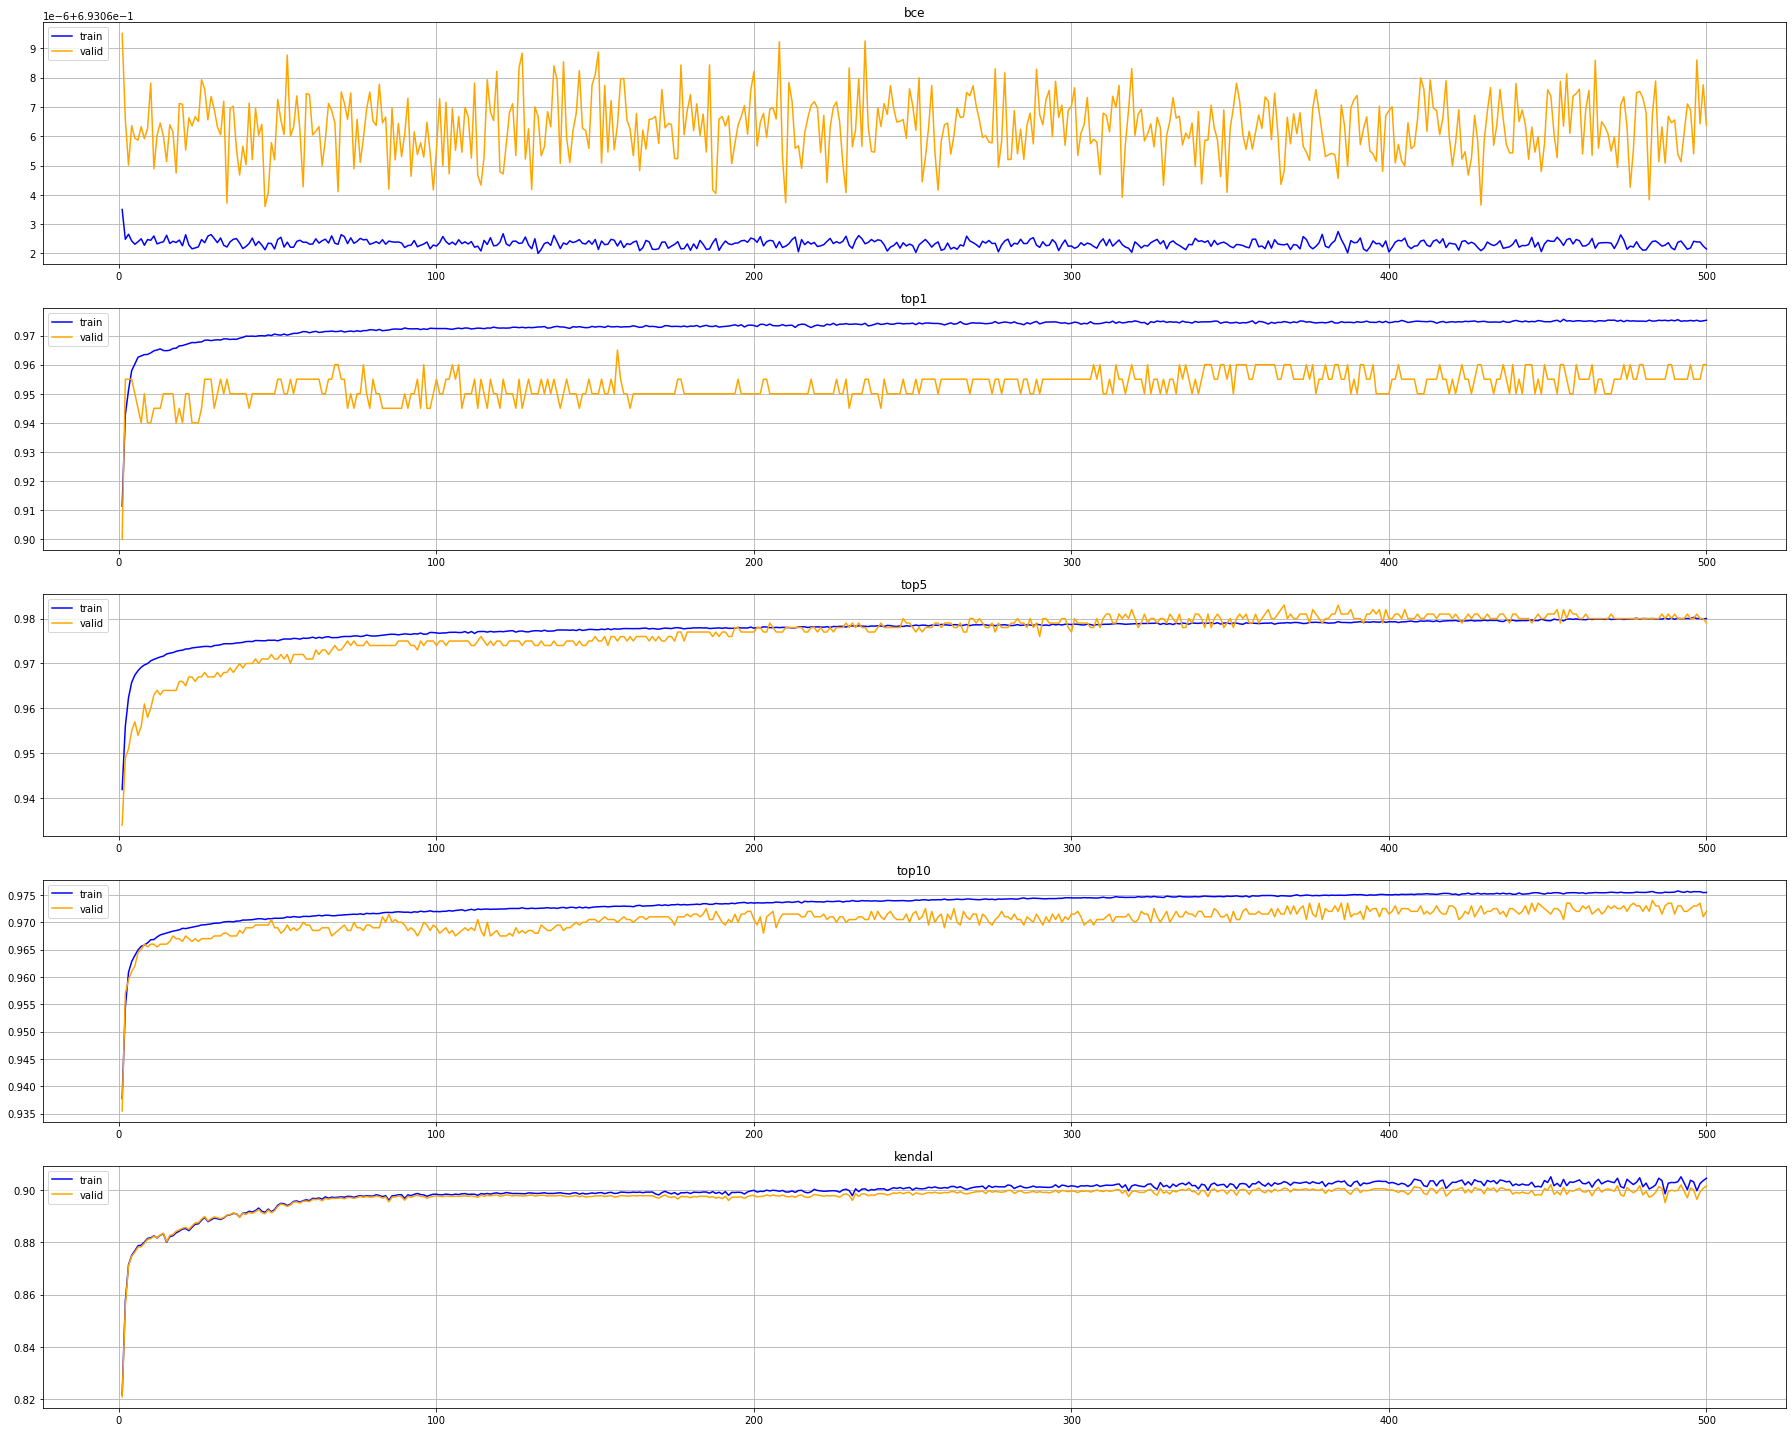

In [38]:
drbc.visualize_plt(setting.train_info_p, setting.val_info_p, setting.result_plt_p)